# Simulation plots

In [2]:
import numpy as np
import h5py
import swiftsimio as sw
import matplotlib.pyplot as plt
import pandas as pd
import os

In [3]:
centers = pd.read_csv('centers.txt', names = ['vol_num','X','Y','Z'], index_col=0)

In [4]:
import seaborn as sns
from matplotlib import cycler
clrs = sns.color_palette('Accent', n_colors=26)
colors = cycler('color', list(clrs.as_hex()))
font = {'family' : 'serif',
        'serif': 'Times New Roman'}

plt.rc('axes', axisbelow=True, 
       grid=False, prop_cycle=colors)
plt.rc('xtick', direction='in')
plt.rc('ytick', direction='in')
plt.rc('font', **font)

In [5]:
#_i is always index from the catalogue, 
#and _ids is id from the catalogue
class SimTools():
    def __init__(self, catalogue, snapshot, membership_file, siminfo_file, volume_num):
        self.catalogue_file = catalogue
        self.snapshot = snapshot
        self.membership_file = membership_file
        self.siminfo_file = siminfo_file
        self.mstar = None
        self.mtotal = None
        self.soap = h5py.File(self.catalogue_file, 'r') # Read in SOAP property file
        self.field = np.array(self.soap['VR/HostHaloID']) #all satellites have a host halo id that points towards the satellite
        self.vol = volume_num
        self.halo_ids = self.soap['VR/ID']
        self.host_halo_ids = np.array(self.soap['VR/ID'])[self.field==-1]
        self.host_halo_i = np.array(self.host_halo_ids)-1
        
        with open(self.siminfo_file, 'r') as f:
            lines = f.readlines()
        for line in lines:
            if 'h_val' in line:
                parts = line.split()
                self.h_val = float(parts[2])
                break
        
    def getHaloMasses(self):
        self.mtotal = np.array(self.soap['BoundSubhaloProperties/TotalMass']) # Not m200 anymore
        try:
            self.mstar = np.array(self.soap['ExclusiveSphere/30kpc/StellarMass'])
        except KeyError:
            print('looking somewhere else')
            self.mtotal = np.array(self.soap['BoundSubhaloProperties/StellarMass'])

        return self.mtotal, self.mstar

    def getHaloDarkMatterMembers(self, halo_i):
        #halo INDEX is not halo ID
        # function to read in bound DM particles for a given halo
        members = h5py.File(self.membership_file, 'r') # Membership data
        host_halo_ids = np.array(members['PartType1/GroupNr_bound'])
        bound_particles = np.where(host_halo_ids == halo_i) # Find index of particles bound to given halo

        data = sw.load(self.snapshot) # Load snapshot data
        positions = data.dark_matter.coordinates # Coordinates of dark matter particles in simulation - can replace for gas, stars and properties like mass etc.
        self.positions = positions[bound_particles] # Mask for particles bound to given halo

        return self.positions

    def getHaloStarsMembers(self, halo_i):
        members = h5py.File(self.membership_file, 'r') # Membership data
        host_halo_ids = np.array(members['PartType4/GroupNr_bound']) # Gives the host halo ID that each particle is bound to
        bound_particles = np.where(host_halo_ids == halo_i) # Find index of particles bound to given halo

        data = sw.load(self.snapshot) # Load snapshot data
        positions = data.stars.coordinates # Coordinates of dark matter particles in simulation - can replace for gas, stars and properties like mass etc.
        self.star_positions = positions[bound_particles] # Mask for particles bound to given halo

        return self.star_positions
    
    def calc_r200(self, host_i):
        m200 = np.array(self.soap['SO/200_crit/TotalMass'])[host_i] #mass is in solar mass
        
        H = self.h_val*100 #converting from H/100 to h
        G = 4.3e-9 #converting from pc to Mpc
        rho_crit = 3*(H**2)/(8*np.pi*G)
        r200 = (m200/(4/3. * np.pi * 200*rho_crit))**(1/3)*1000
        return r200
            
    def make_volume_table(self):
        if self.mstar is None or self.mtotal is None:
            self.getHaloMasses()
        
        host_r200 = [self.calc_r200(i) for i in range(len(self.host_halo_i))]
        host_v200 = host_r200*self.h_val
        host_CoM = self.soap['BoundSubhaloProperties/CentreOfMass'][self.host_halo_i].tolist()
        host_tot_mass = [self.mtotal[i] for i in self.host_halo_i]
        host_stellar_mass = [self.mstar[i] for i in self.host_halo_i]
        #----new----
        host_corot = self.soap['ExclusiveSphere/30kpc/KappaCorotStars'][self.host_halo_i].tolist()
        host_atomicH = self.soap['ExclusiveSphere/30kpc/AtomicHydrogenMass'][self.host_halo_i].tolist()
        host_gasM = self.soap['BoundSubhaloProperties/GasMass'][self.host_halo_i].tolist()
        host_vmax = self.soap['BoundSubhaloProperties/MaximumCircularVelocity'][self.host_halo_i].tolist()
        host_v_vec = self.soap['BoundSubhaloProperties/CentreOfMassVelocity'][self.host_halo_i].tolist()
        host_halfM_radius = self.soap['ExclusiveSphere/30kpc/HalfMassRadiusStars'][self.host_halo_i].tolist()
        host_metalfrac = self.soap['ExclusiveSphere/30kpc/StellarMassFractionInMetals'][self.host_halo_i].tolist()
        host_ironfrac = self.soap['ExclusiveSphere/30kpc/StellarMassFractionInIron'][self.host_halo_i].tolist()
        host_vel_dispersion = self.soap['ExclusiveSphere/30kpc/StellarVelocityDispersionMatrix'][self.host_halo_i].tolist()
        #-------------
        sat_ids = [self.halo_ids[self.field == i].tolist() for i in self.host_halo_ids]
        sat_i = [(np.array(ids) - 1).tolist() for ids in sat_ids]
        sat_CoM = []
        sat_tot_mass = []
        sat_stellar_mass = []
        #---new---
        sat_atomicH = []
        sat_gasM = []
        sat_halfM_radius = []
        sat_metalfrac = []
        sat_ironfrac = []
        sat_vel_dispersion = []
        sat_vmax = []
        sat_v_vec = []
        #---------
        for i in sat_i:
            sat_CoM.append(self.soap['BoundSubhaloProperties/CentreOfMass'][i].tolist())
            sat_tot_mass.append(self.mtotal[i].tolist())
            sat_stellar_mass.append(self.mstar[i].tolist())
            #---new---
            sat_atomicH.append(self.soap['ExclusiveSphere/30kpc/AtomicHydrogenMass'][i].tolist())
            sat_gasM.append(self.soap['BoundSubhaloProperties/GasMass'][i].tolist())
            sat_halfM_radius.append(self.soap['ExclusiveSphere/30kpc/HalfMassRadiusStars'][i].tolist())
            sat_metalfrac.append(self.soap['ExclusiveSphere/30kpc/StellarMassFractionInMetals'][i].tolist())
            sat_ironfrac.append(self.soap['ExclusiveSphere/30kpc/StellarMassFractionInIron'][i].tolist())
            sat_vel_dispersion.append(self.soap['ExclusiveSphere/30kpc/StellarVelocityDispersionMatrix'][i].tolist())
            sat_vmax.append(self.soap['BoundSubhaloProperties/MaximumCircularVelocity'][i].tolist())
            sat_v_vec.append(self.soap['BoundSubhaloProperties/CentreOfMassVelocity'][i].tolist())
            #---------

        vol = [self.vol] * len(self.host_halo_i)


        data_dict = {
            'Volume': vol,
            'Host i': self.host_halo_i,
            'Host ID': self.host_halo_ids,
            'Host R200': host_r200,
            'Host V200': host_v200,
            'Host CoM': host_CoM,
            'Host Mtot': host_tot_mass,
            'Host M*': host_stellar_mass,
            'Host KappaCorot':host_corot,
            'Host Mhyd': host_atomicH,
            'Host Mgas':host_gasM,
            'Host HalfM* radius':host_halfM_radius,
            'Host M* Metal':host_metalfrac,
            'Host M* Iron':host_ironfrac,
            'Host vel': host_vel_dispersion,
            'Host Vmax': host_vmax,
            'Host CoMV': host_v_vec,
            'Sat i': sat_i,
            'Sat ID': sat_ids,
            'Sat CoM': sat_CoM,
            'Sat Mtot': sat_tot_mass,
            'Sat M*': sat_stellar_mass,
            'Sat Mhyd': sat_atomicH,
            'Sat Mgas':sat_gasM,
            'Sat HalfM* radius':sat_halfM_radius,
            'Sat M* Metal':sat_metalfrac,
            'Sat M* Iron':sat_ironfrac,
            'Sat vel': sat_vel_dispersion,
            'Sat Vmax': sat_vmax,
            'Sat CoMV': sat_v_vec,
        }

        df = pd.DataFrame(data_dict)
        self.main_df = df

        filename = f"data/volume_number_{self.vol}.csv"
        self.main_df.to_csv(filename, index=False)
        
        return self.main_df
    
    #=============PLOTS===============
    def plotBoxParticleDistribution(self):
        data = sw.load(self.snapshot) #read final snapshot
        pos = data.dark_matter.coordinates
        plt.figure(dpi=200)
        plt.plot(pos[::10,0], pos[::10,2],'k.', markersize=0.25, alpha=0.01)
        side_length = 0.20
        center_x = 381.5
        center_y = 160
        # Calculate the bottom left corner of the square
        bottom_left_x = center_x - side_length / 2
        bottom_left_y = center_y - side_length / 2

        # Square box around the center
        #square_box = plt.Rectangle((bottom_left_x, bottom_left_y), side_length, side_length, edgecolor='r', facecolor='none')
        #plt.gca().add_patch(square_box)
        plt.show()

    def plot_particles(self, host_i, df):
        host_halo_part = self.getHaloDarkMatterMembers(host_i)
        host_star_part = self.getHaloStarsMembers(host_i)
        sat_halo_part = []
        sat_star_part = []
        for i in df.loc[host_i]['Sat i']:
            sat_halo_part.append(self.getHaloDarkMatterMembers(i-1))
            sat_star_part.append(self.getHaloStarsMembers(i-1))    
        
        fig, ax = plt.subplots(1, 2, dpi=200, figsize = (12,7))
        ax[0].scatter(host_halo_part[:,1], host_halo_part[:,2], s=1, alpha = 0.2, c='black')
        ax[1].scatter(host_star_part[:,1], host_star_part[:,2], s=1, alpha = 0.2, c='black')
        for sat in sat_halo_part:
            ax[0].scatter(np.array(sat)[:,1], np.array(sat)[:,2], s=1, alpha=0.2, c='red')
        for sat in sat_star_part:
            ax[1].scatter(np.array(sat)[:,1], np.array(sat)[:,2], s=1, alpha=0.2, c='red')
        ax[1].set_title(f'Star particles of halo {host_i+1} and satellites')
        ax[0].set_title(f'Dark matter particles of halo {host_i+1} and satellites')
        fig.show()

class SimToolsPlotting():
    def __init__(self, folder_path):
        # Initialize by reading and combining CSV files
        if folder_path.endswith('.csv'):
            main_df = pd.read_csv(folder_path, converters={'Host CoM':pd.eval, 'Host CoMV':pd.eval, 'Sat ID':pd.eval, 'Sat i':pd.eval, 'Sat Mtot':pd.eval, 'Sat M*':pd.eval, 'Sat CoM': pd.eval, 'Sat Mhyd': pd.eval,
            'Sat Mgas':pd.eval,
            'Sat HalfM* radius':pd.eval,
            'Sat M* Metal':pd.eval,
            'Sat M* Iron':pd.eval,
            'Sat vel': pd.eval,
            'Sat Vmax': pd.eval,
            'Sat CoMV': pd.eval})
            self.main_df = main_df
        else:
            self.main_df = self.read_and_combine_csvs(folder_path)
        self.vol = self.get_volume_number(self.main_df)
        self.mtotal = np.array(list(self.main_df['Host Mtot']) + [val for sublist in self.main_df['Sat Mtot'] for val in sublist])
        self.mstar = np.array(list(self.main_df['Host M*']) + [val for sublist in self.main_df['Sat M*'] for val in sublist])
        self.sat_cols = ['Sat CoM', 'Sat ID', 'Sat M*', 'Sat Mtot', 'Sat i', 'Sat Mhyd', 'Sat Mgas', 'Sat HalfM* radius', 'Sat M* Metal', 'Sat M* Iron', 'Sat vel', 'Sat Vmax', 'Sat CoMV']

    def get_volume_number(self, df):
        if 'Volume' in df.columns:
            return df['Volume'].iloc[0]
        else:
            raise ValueError("Volume number column not found in dataframe")

    def read_and_combine_csvs(self, folder_path):
        # Initialize an empty list to store the dataframes
        dfs = []

        # Loop through all files in the folder
        for filename in os.listdir(folder_path):
            if filename.endswith('.csv'):
                # Read each CSV file
                df = pd.read_csv(os.path.join(folder_path, filename), converters={
                    'Host CoM': pd.eval, 'Host CoMV': pd.eval, 'Sat ID': pd.eval, 'Sat i': pd.eval, 'Sat Mtot': pd.eval, 'Sat M*': pd.eval, 'Sat CoM': pd.eval, 'Sat Mhyd': pd.eval,
                    'Sat Mgas': pd.eval, 'Sat HalfM* radius': pd.eval, 'Sat M* Metal': pd.eval, 'Sat M* Iron': pd.eval, 'Sat vel': pd.eval, 'Sat Vmax': pd.eval, 'Sat CoMV': pd.eval
                })
                # Append the dataframe to the list
                dfs.append(df)

        # Concatenate all dataframes in the list
        combined_df = pd.concat(dfs, ignore_index=True)
        
        return combined_df
    
    def getCentralHalos(self, distance_cut=True, dist_from_center = 5):
        center = np.array([float(c) for c in centers.loc[self.vol]])

        #get massive host halos
        central_df = self.main_df.loc[(self.main_df['Host M*']>1e9)]
        #get halos within 5Mpc of volume center and 
        self.center_distance_mask = []
        for i in central_df['Host i']:
            val = all(np.abs(central_df['Host CoM'].loc[i]-center) < dist_from_center)
            self.center_distance_mask.append(val)

        self.central_df = central_df.loc[self.center_distance_mask]

        if distance_cut:
            for i in self.central_df['Host i']:
                # Distance cut of satellites
                r200 = self.central_df['Host R200'].loc[i]
                host_center = np.array(self.central_df['Host CoM'].loc[i])
                satellite_centers = self.central_df['Sat CoM'].loc[i]
                distances = np.array([np.linalg.norm(np.array(sat) - host_center) for sat in satellite_centers]) * 1000
                distance_mask = distances < r200
                for col in self.sat_cols:
                    self.central_df[col].at[i] = np.array(self.central_df[col].loc[i])[distance_mask].tolist()
        else:
            pass

        return self.central_df
    
        
#===========PLOTS============================

    def plotStellarMassHaloMass_all(self):
        sorted_idx = np.argsort(self.mstar)
        fig, ax = plt.subplots(dpi=150)
        ax.scatter(self.mtotal[sorted_idx], self.mstar[sorted_idx], s = 7)
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_xlabel('Total Mass')
        ax.set_ylabel('M*')
        ax.set_ylim(1e5,1e9)
        ax.set_xlim(1e8,1e11)
        ax.set_title('Stellar Mass - Total Mass relation')
        fig.show()
    
    def plotFieldHaloMassDist(self):
        fig, axs = plt.subplots(1, 2, figsize=(12,5), dpi=150)
        axs[0].hist(np.log10(np.ma.array(self.main_df['Host Mtot'])))
        axs[1].hist(np.log10(np.ma.array(self.main_df['Host M*'])))
        for ax in axs: 
            ax.set_ylabel('N')
            ax.set_yscale('log')
            ax.set_xlabel(r'$log_{10}(M200)$')
        axs[0].set_title('Total mass distribution')
        axs[1].set_title('Stellar mass distribution')
        axs[0].vlines(9, 0, 1e3, 'r','--')
        fig.suptitle('Field Halo mass distributions')
        fig.show()

    def number_plots(self, mstar_cut=True):        
        fig, ax = plt.subplots(3, 2, figsize = (10, 10), dpi=150, constrained_layout=True)
        ax_flat = ax.flatten()
        central_df = self.central_df.copy(deep=True)

        # Do mass cut of all satellite halos if mass_cut=True
    
        for i in self.central_df['Host i']:
            mtot_mask = np.array(self.central_df['Sat Mtot'].loc[i]) > 10**7
            mstar_mask = np.array(self.central_df['Sat M*'].loc[i]) > 1e5
            for col in self.sat_cols:
                if mstar_cut:
                    central_df[col].at[i] = np.array(self.central_df[col].loc[i])[mtot_mask & mstar_mask]
                else:
                    central_df[col].at[i] = np.array(self.central_df[col].loc[i])[mtot_mask]

        for i in central_df['Host i']:
            r200 = central_df['Host R200'].loc[i]
            host_center = np.array(central_df['Host CoM'].loc[i])
            satellite_centers = central_df['Sat CoM'].loc[i]
            distances = np.array([np.linalg.norm(np.array(sat) - host_center) for sat in satellite_centers]) * 1000

            arrays = {
                'distance': distances,
                'distance_norm': distances / r200,
                'mstar': central_df['Sat M*'].loc[i], 
                'mtotal': central_df['Sat Mtot'].loc[i], 
                'mstar_norm': central_df['Sat M*'].loc[i] / central_df.loc[i]['Host M*'], 
                'mtotal_norm': central_df['Sat Mtot'].loc[i] / central_df.loc[i]['Host Mtot']
            }
            
            # Loop over the first 6 keys in the arrays dictionary
            for j, key in enumerate(list(arrays.keys())):
                # Get the x values and sort them in reverse order
                x_values = sorted(arrays[key], reverse=True)

                # Determine y values
                if key == 'distance' or key == 'distance_norm':
                    y_values = np.linspace(len(x_values), 1, len(x_values)) / len(x_values)
                else:
                    ax_flat[j].set_xscale('log')
                    y_values = np.arange(1, len(x_values) + 1)

                # Plot the values with a label for the host index
                host_id = self.central_df.loc[i]['Host ID']
                ax_flat[j].plot(x_values, y_values, '-', label=f'Host {host_id}')
                ax_flat[j].set_title(key)
                ax_flat[j].legend()

        ax_flat[0].set_xlabel('r (kpc)')
        ax_flat[0].set_ylabel('N(<r200)/Ntot')

        ax_flat[1].set_xlabel(r'r/$R_{200}$ (kpc)')
        ax_flat[1].set_ylabel('N(<r200)/Ntot')

        ax_flat[2].set_xlabel(r'M* ($M_\odot$)')
        ax_flat[2].set_ylabel('N(<M*)')
        #ax_flat[2].set_yscale('log')

        ax_flat[3].set_xlabel(r'$M_{tot}$ ($M_{\odot}$)')
        ax_flat[3].set_ylabel(r'$N(<M_{tot})$')
        #ax_flat[3].set_yscale('log')

        ax_flat[4].set_xlabel(r'$M*/M*_{host}$ ($M_{\odot}$)')
        ax_flat[4].set_ylabel(r'$N(<M*/M*_{host})$')
        #ax_flat[4].set_yscale('log')

        ax_flat[5].set_xlabel(r'$M_{tot}/M_{tot} host$ ($M_{\odot}$)')
        ax_flat[5].set_ylabel(r'N(<$M_{tot}/M_{tot} host$)')
        #ax_flat[5].set_yscale('log')

        fig.suptitle(f'Individual Central halo satellite properties {self.vol}')

        plt.show()

    def avg_number_plots(self, mstar_cut=True):
        fig, ax = plt.subplots(3, 2, figsize = (10, 10), dpi=150, constrained_layout=True)
        ax_flat = ax.flatten()
        arrays = {
            'distance': [],
            'distance_norm': [],
            'mstar': [], 
            'mtotal': [], 
            'mstar_norm': [], 
            'mtotal_norm': []
        }
        central_df = self.central_df.copy(deep=True)

    
        mtot_mask = [np.array(self.central_df['Sat Mtot'].loc[i]) > 10**7 for i in self.central_df['Host i']]
        mstar_mask = [np.array(self.central_df['Sat M*'].loc[i]) > 1e5 for i in self.central_df['Host i']]
        for col in self.sat_cols:
            for i in range(len(mtot_mask)):
                if mstar_cut:
                    central_df[col].iat[i] = np.array(self.central_df[col].iloc[i])[mtot_mask[i] & mstar_mask[i]]
                    

        for i in central_df['Host i']:
            r200 = central_df['Host R200'].loc[i]
            host_center = np.array(central_df['Host CoM'].loc[i])
            satellite_centers = central_df['Sat CoM'].loc[i]
            distances = np.array([np.linalg.norm(np.array(sat) - host_center) for sat in satellite_centers]) * 1000

            sat_mstar = central_df['Sat M*'].loc[i]
            sat_mtot = central_df['Sat Mtot'].loc[i]

            arrays['distance'].append(distances)
            arrays['distance_norm'].append(distances / r200)
            arrays['mstar'].append(sat_mstar)
            arrays['mtotal'].append(sat_mtot)
            arrays['mstar_norm'].append(sat_mstar / central_df.loc[i]['Host M*'])
            arrays['mtotal_norm'].append(sat_mtot / central_df.loc[i]['Host Mtot'])
            
        # Loop over the first 6 keys in the arrays dictionary
        for j, key in enumerate(list(arrays.keys())):
            arrays[key] = np.concatenate(arrays[key])
            # Get the x values and sort them in reverse order
            x_values = sorted(arrays[key], reverse=True)

            # Determine y values
            if key == 'distance' or key == 'distance_norm':
                y_values = np.linspace(len(x_values), 1, len(x_values)) / len(x_values)
            else:
                ax_flat[j].set_xscale('log')
                y_values = np.arange(1, len(x_values) + 1)
                y_values = y_values / len(central_df)

            # Plot the values with a label for the host index
            ax_flat[j].plot(x_values, y_values, '-')
            ax_flat[j].set_title(key)

        ax_flat[0].set_xlabel('r (kpc)')
        ax_flat[0].set_ylabel('N(<r200)/Ntot')

        ax_flat[1].set_xlabel(r'r/$R_{200}$ (kpc)')
        ax_flat[1].set_ylabel('N(<r200)/Ntot')

        ax_flat[2].set_xlabel(r'M* ($M_\odot$)')
        ax_flat[2].set_ylabel('N(<M*)')
        #ax_flat[2].set_yscale('log')

        ax_flat[3].set_xlabel(r'$M_{tot}$ ($M_{\odot}$)')
        ax_flat[3].set_ylabel(r'$N(<M_{tot})$')
        #ax_flat[3].set_yscale('log')

        ax_flat[4].set_xlabel(r'$M*/M*_{host}$ ($M_{\odot}$)')
        ax_flat[4].set_ylabel(r'$N(<M*/M*_{host})$')
        #ax_flat[4].set_yscale('log')

        ax_flat[5].set_xlabel(r'$M_{tot}/M_{tot} host$ ($M_{\odot}$)')
        ax_flat[5].set_ylabel(r'N(<$M_{tot}/M_{tot} host$)')
        #ax_flat[5].set_yscale('log')

        fig.suptitle(f'Central halo satellite properties for Vol {self.vol}')

        plt.show()

    def lum_nonlum_number_plots(self):
        fig, ax = plt.subplots(3, 2, figsize = (10, 10), dpi=150, constrained_layout=True)
        ax_flat = ax.flatten()
        arrays = {
            'distance': [],
            'distance_norm': [],
            'mstar': [],  
            'mtotal': [],
            'mstar_norm': [], 
            'mtotal_norm': []
        }
        central_df = self.central_df.copy(deep=True)

        mtot_mask = [np.array(self.central_df['Sat Mtot'].loc[i]) > 10**7 for i in self.central_df['Host i']]
        for col in self.sat_cols:
            for i in range(len(mtot_mask)):
                central_df[col].iat[i] = np.array(self.central_df[col].iloc[i])[mtot_mask[i]]

        for i in central_df['Host i']:
            r200 = central_df['Host R200'].loc[i]
            host_center = np.array(central_df['Host CoM'].loc[i])
            satellite_centers = central_df['Sat CoM'].loc[i]
            distances = np.array([np.linalg.norm(np.array(sat) - host_center) for sat in satellite_centers]) * 1000

            sat_mstar = central_df['Sat M*'].loc[i]
            sat_mtot = central_df['Sat Mtot'].loc[i]

            arrays['distance'].append(distances)
            arrays['distance_norm'].append(distances / r200)
            arrays['mstar'].append(sat_mstar)
            arrays['mtotal'].append(sat_mtot)
            arrays['mstar_norm'].append(sat_mstar / central_df.loc[i]['Host M*'])
            arrays['mtotal_norm'].append(sat_mtot / central_df.loc[i]['Host Mtot'])

        non_zero_mask = np.concatenate([array != 0 for array in arrays['mstar']])
        
        for j, key in enumerate(list(arrays.keys())):
            if key == 'distance' or key == 'distance_norm':
                arrays[key] = np.concatenate(arrays[key])

                nonzero_x_values = sorted(arrays[key][non_zero_mask], reverse=True)
                total_x_values = sorted(arrays[key], reverse=True)

                #differentiate between luminous and non-luminous satellites here
                nonzero_y_values = np.linspace(len(nonzero_x_values), 1, len(nonzero_x_values)) / len(nonzero_x_values)
                total_y_values = np.linspace(len(total_x_values), 1, len(total_x_values)) / len(total_x_values)
                # Plot the values with a label for the host index
                ax_flat[j].plot(nonzero_x_values, nonzero_y_values, 'r', label='Luminous satellites')
                ax_flat[j].plot(total_x_values, total_y_values, 'b', label='Total satellites')
                ax_flat[j].set_title(key)
                ax_flat[j].legend()

            elif key == 'mtotal' or key == 'mtotal_norm':
                arrays[key] = np.concatenate(arrays[key])
                
                nonzero_x_values = sorted(arrays[key][non_zero_mask], reverse=True)
                total_x_values = sorted(arrays[key], reverse=True)

                nonzero_y_values = np.arange(1, len(nonzero_x_values)+1)/len(central_df)
                total_y_values = np.arange(1, len(total_x_values)+1)/len(central_df)
                # Plot the values with a label for the host index
                ax_flat[j].plot(nonzero_x_values, nonzero_y_values, c='r', label='Luminous satellites')
                ax_flat[j].plot(total_x_values, total_y_values, c='b', label='Total satellites')
                ax_flat[j].set_title(key)
                ax_flat[j].legend()

            else:
                mstar_cut_mask = np.concatenate([np.array(array) > 1e5 for array in arrays['mstar']])
                mstar_concatenated = np.concatenate(arrays[key])[mstar_cut_mask]
                x_values_conc = sorted(mstar_concatenated, reverse=True)
                ax_flat[j].set_xscale('log')
                y_values_conc = np.arange(1, len(x_values_conc) + 1) / len(central_df)
                # Plot the values with a label for the host index
                ax_flat[j].plot(x_values_conc, y_values_conc, 'b', '-')
                ax_flat[j].set_title(key)
                #Add the individual host plots:
                for array in arrays[key]:
                    x_values = sorted(array, reverse=True)
                    y_values = np.arange(1, len(x_values)+1)
                    ax_flat[j].plot(x_values, y_values, alpha=0.5, c='gray')

        ax_flat[0].set_xlabel('r (kpc)')
        ax_flat[0].set_ylabel('N(<r200)/Ntot')

        ax_flat[1].set_xlabel(r'r/$R_{200}$ (kpc)')
        ax_flat[1].set_ylabel('N(<r200)/Ntot')

        ax_flat[2].set_xlabel(r'M* ($M_\odot$)')
        ax_flat[2].set_ylabel('N(>M*)')
        #ax_flat[2].set_yscale('log')

        ax_flat[3].set_xlabel(r'$M_{tot}$ ($M_{\odot}$)')
        ax_flat[3].set_ylabel(r'$N(>M_{tot})$')
        ax_flat[3].set_xscale('log')

        ax_flat[4].set_xlabel(r'$M*/M*_{host}$ ($M_{\odot}$)')
        ax_flat[4].set_ylabel(r'$N(>M*/M*_{host})$')
        #ax_flat[4].set_yscale('log')

        ax_flat[5].set_xlabel(r'$M_{tot}/M_{tot} host$ ($M_{\odot}$)')
        ax_flat[5].set_ylabel(r'N(>$M_{tot}/M_{tot} host$)')
        ax_flat[5].set_xscale('log')

        fig.suptitle(f'Central halo satellite properties for Vol {self.vol}')

        plt.show()

    def smhm_centralhalos(self):
        #make stellar mass hallo mass plots for each host and its respective satelites
        fig, ax = plt.subplots(dpi=150, constrained_layout=True)
        cmap = plt.get_cmap('Set1')
        for i in range(len(self.central_df['Host i'])):
            host_id = self.central_df['Host ID'].iloc[i]
            ax.scatter(self.central_df['Host Mtot'].iloc[i], self.central_df['Host M*'].iloc[i], s=20, color = cmap(i), label=f'Host {host_id}', marker='*')
            sat_mstar_array = np.array(self.central_df['Sat M*'].iloc[i])
            # Replace 0 values with 10^4
            sat_mstar_array[sat_mstar_array == 0.0] = 10**3.5
            ax.scatter(self.central_df['Sat Mtot'].iloc[i], sat_mstar_array, s=3, color = 'Blue', alpha = 0.5, label=f'Satellites {host_id}')
        ax.scatter(self.main_df['Host Mtot'], self.main_df['Host M*'], c='Gray', s=2, alpha=0.2)

        ax.set_xlabel('Total Mass')
        ax.set_ylabel('Stellar Mass')

        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.legend()
        fig.suptitle(f'Central Halo SHMH Volume {self.vol}')
        fig.show()


In [4]:
vols = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25']
for v in vols:
    SOAP_fname = f'/cosma8/data/dp004/dc-brig2/Columba/HYDRO/m5/volume{v}/SOAP_halo_properties_0063.hdf5'
    SOAP_membership = f'/cosma8/data/dp004/dc-brig2/Columba/HYDRO/m5/volume{v}/SOAP_membership_0063.hdf5'
    snapshot = f'/cosma8/data/dp004/dc-brig2/Columba/HYDRO/m5/volume{v}/snapshot_0063.hdf5'
    siminfo_file = f'/cosma8/data/dp004/dc-brig2/Columba/HYDRO/m5/volume{v}/halo_0063.siminfo'
    vol15_sim = SimTools(SOAP_fname, snapshot, SOAP_membership, siminfo_file, v)
    vol15_main_df = vol15_sim.make_volume_table()

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/cosma8/data/dp004/dc-brig2/Columba/HYDRO/m5/volume01/SOAP_halo_properties_0063.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [9]:
csv_file = 'data/volume_number_15.csv'
vol15_plotsim = SimToolsPlotting(csv_file)
vol15_df = vol15_plotsim.getCentralHalos()
vol15_df


C:\Users\prera\AppData\Local\Temp\ipykernel_10404\1564618298.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.central_df[col].at[i] = np.array(self.central_df[col].loc[i])[distance_mask].tolist()


Volume  Host i  Host ID  Host R200  \
2       15       2        3  115.80215   
3       15       3        4   97.95913   
10      15      10       11   68.63153   

                                             Host CoM     Host Mtot  \
2   [378.7093505859375, 59.60087585449219, 159.142...  1.402230e+11   
3   [379.47265625, 60.62559509277344, 158.08665466...  1.110028e+11   
10  [382.3405456542969, 61.09489059448242, 156.168...  3.482320e+10   

         Host M*  Host KappaCorot     Host Mhyd     Host Mgas  ...  \
2   2.477355e+09         0.590917  2.513197e+08  8.174392e+08  ...   
3   1.125470e+09         0.510516  4.368728e+09  1.277172e+10  ...   
10  1.168635e+09         0.331691  7.838086e+06  3.689922e+07  ...   

                                             Sat Mtot  \
2   [943492800.0, 1202230272.0, 838926272.0, 67970...   
3   [498135360.0, 440326368.0, 311444256.0, 170632...   
10  [241389168.0, 12837824.0, 12101598.0, 10286359...   

                                               Sat M*  \
2   [11367420.0, 2659588.5, 4521123.0, 6252457.0, ...   
3   [0.0, 130808.5078125, 130704.1171875, 0.0, 0.0...   
10  [396299.65625, 131145.59375, 0.0, 0.0, 0.0, 26...   

                                             Sat Mhyd  \
2   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3   [22726536.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
10         [3196509.5, 0.0, 0.0, 0.0, 0.0, 4548042.5]   

                                             Sat Mgas  \
2   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3   [31013736.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   
10         [4406663.5, 0.0, 0.0, 0.0, 0.0, 6263531.5]   

                                    Sat HalfM* radius  \
2   [1.6538989543914795, 0.7676714658737183, 1.118...   
3   [0.0, 0.4276331663131714, 0.2348490208387375, ...   
10  [0.6945297718048096, 0.822282612323761, 0.0, 0...   

                                         Sat M* Metal  \
2   [0.0029211316723376513, 0.001702898065559566, ...   
3   [0.0, 0.0, 0.0, 0.0, 0.0, 0.010164800100028515...   
10   [0.0006072196993045509, 0.0, 0.0, 0.0, 0.0, 0.0]   

                                          Sat M* Iron  \
2   [0.00013474423030856997, 7.018645555945113e-05...   
3   [0.0, 0.0, 0.0, 0.0, 0.0, 0.000657556811347603...   
10  [3.8848607800900936e-05, 0.0, 0.0, 0.0, 0.0, 0.0]   

                                              Sat vel  \
2   [[130.95574951171875, 235.1800537109375, 183.6...   
3   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0....   
10  [[75.72618103027344, 43.970176696777344, 1.052...   

                                             Sat Vmax  \
2   [23.561656951904297, 21.887237548828125, 22.90...   
3   [18.657140731811523, 14.736270904541016, 12.14...   
10  [11.780072212219238, 4.893680095672607, 5.5948...   

                                             Sat CoMV  
2   [[-106.90823364257812, 54.023109436035156, -11...  
3   [[-184.7752685546875, 11.509306907653809, -283...  
10  [[-159.66236877441406, 82.07440948486328, -205...  

[3 rows x 29 columns]

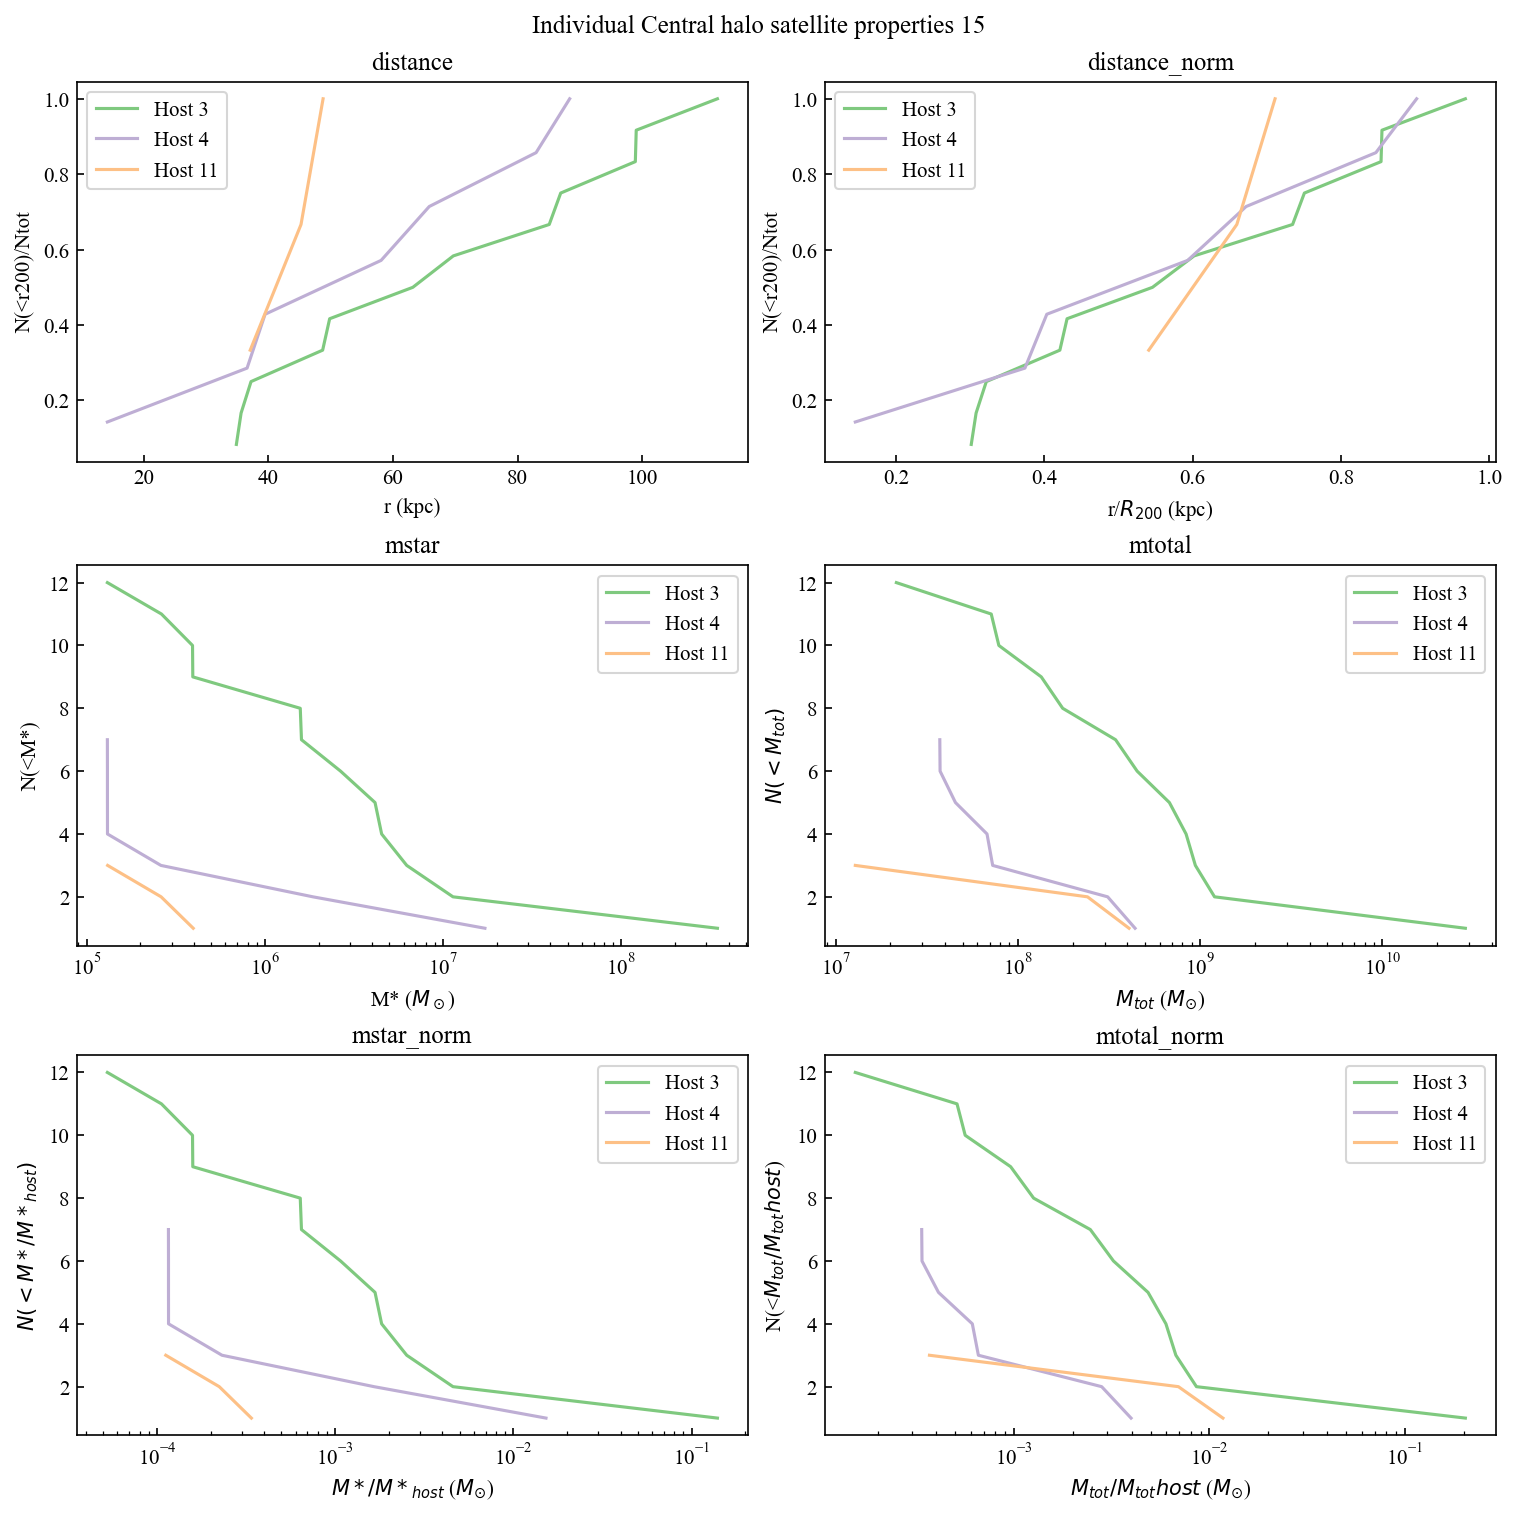

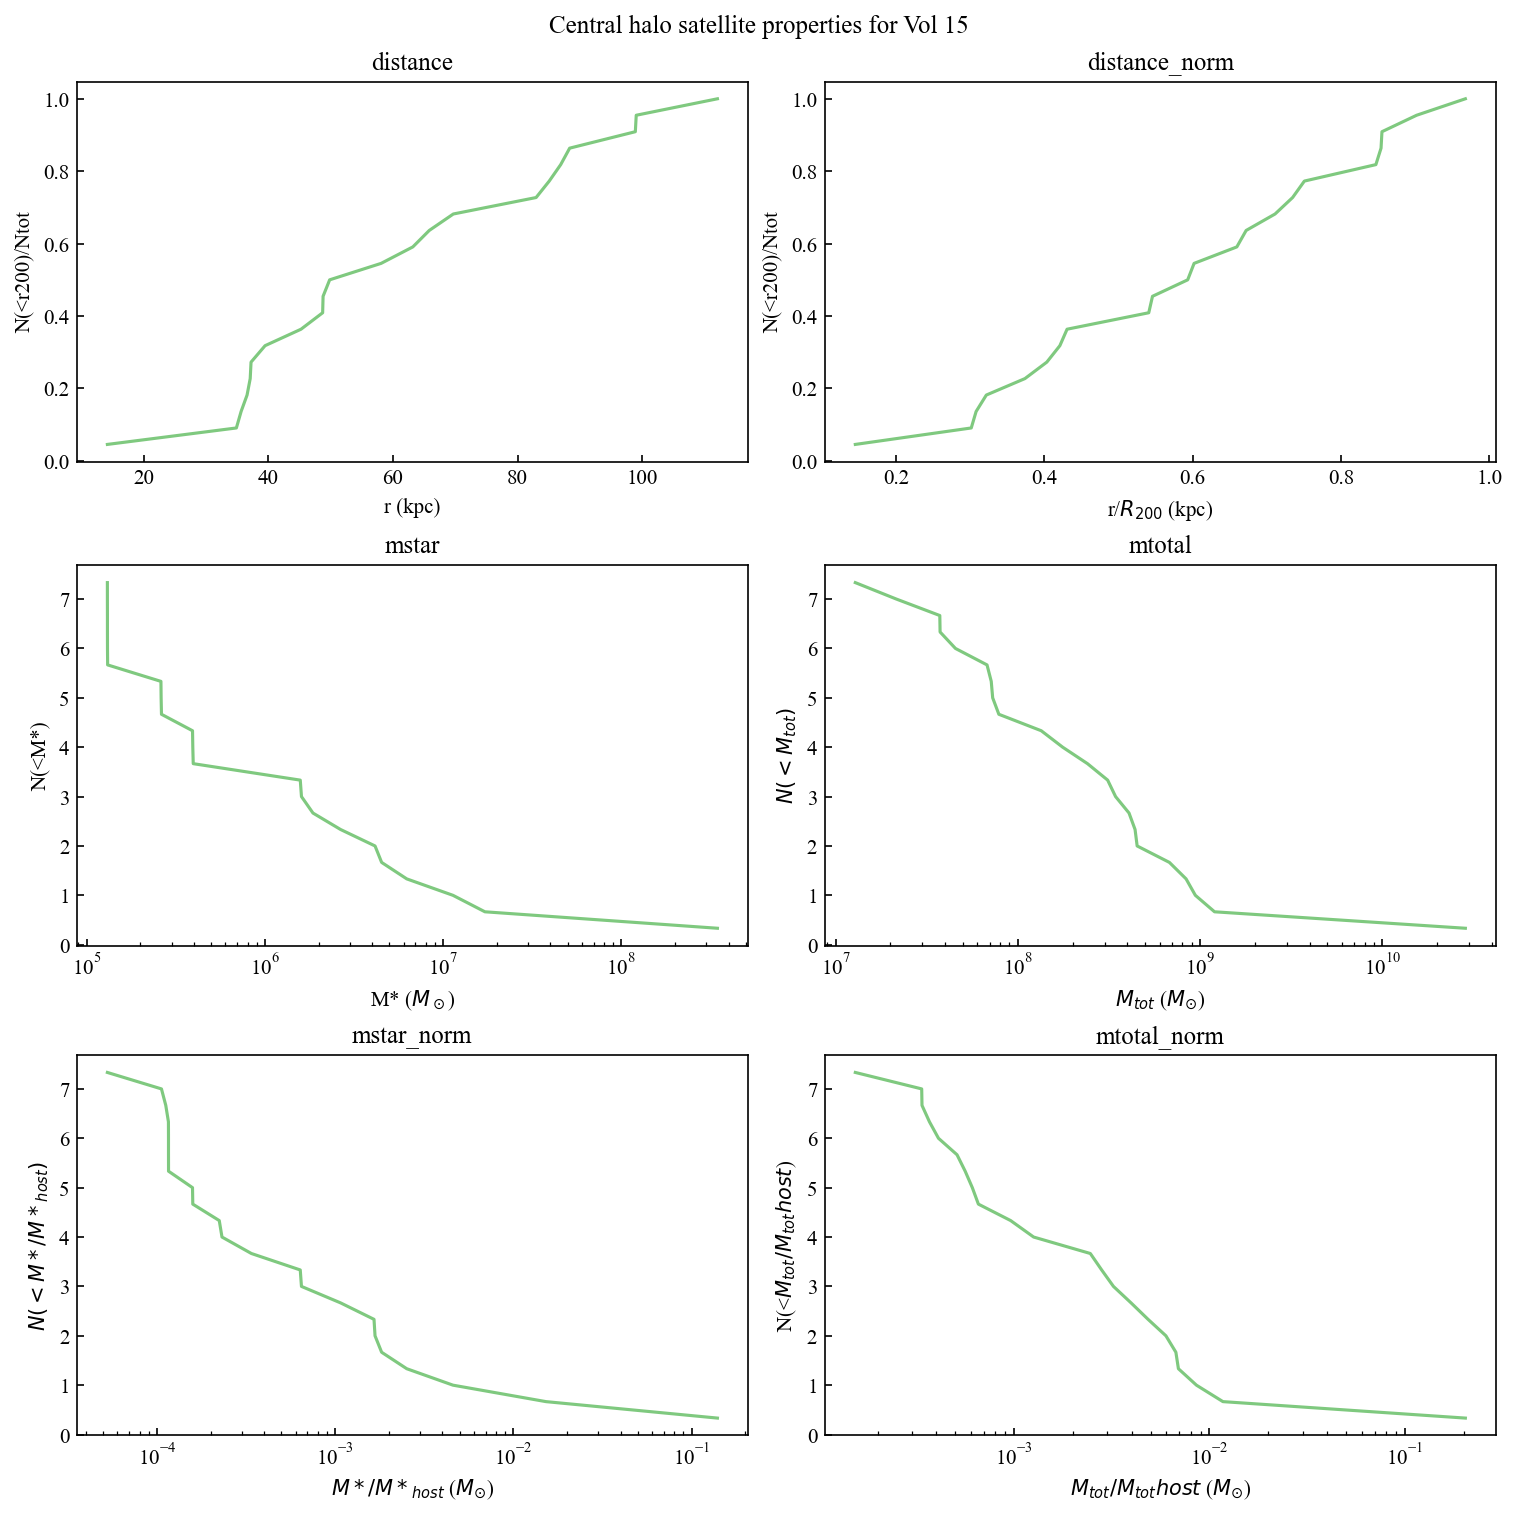

In [24]:
vol15_plotsim.number_plots(mstar_cut=True)
vol15_plotsim.avg_number_plots(mstar_cut=True)

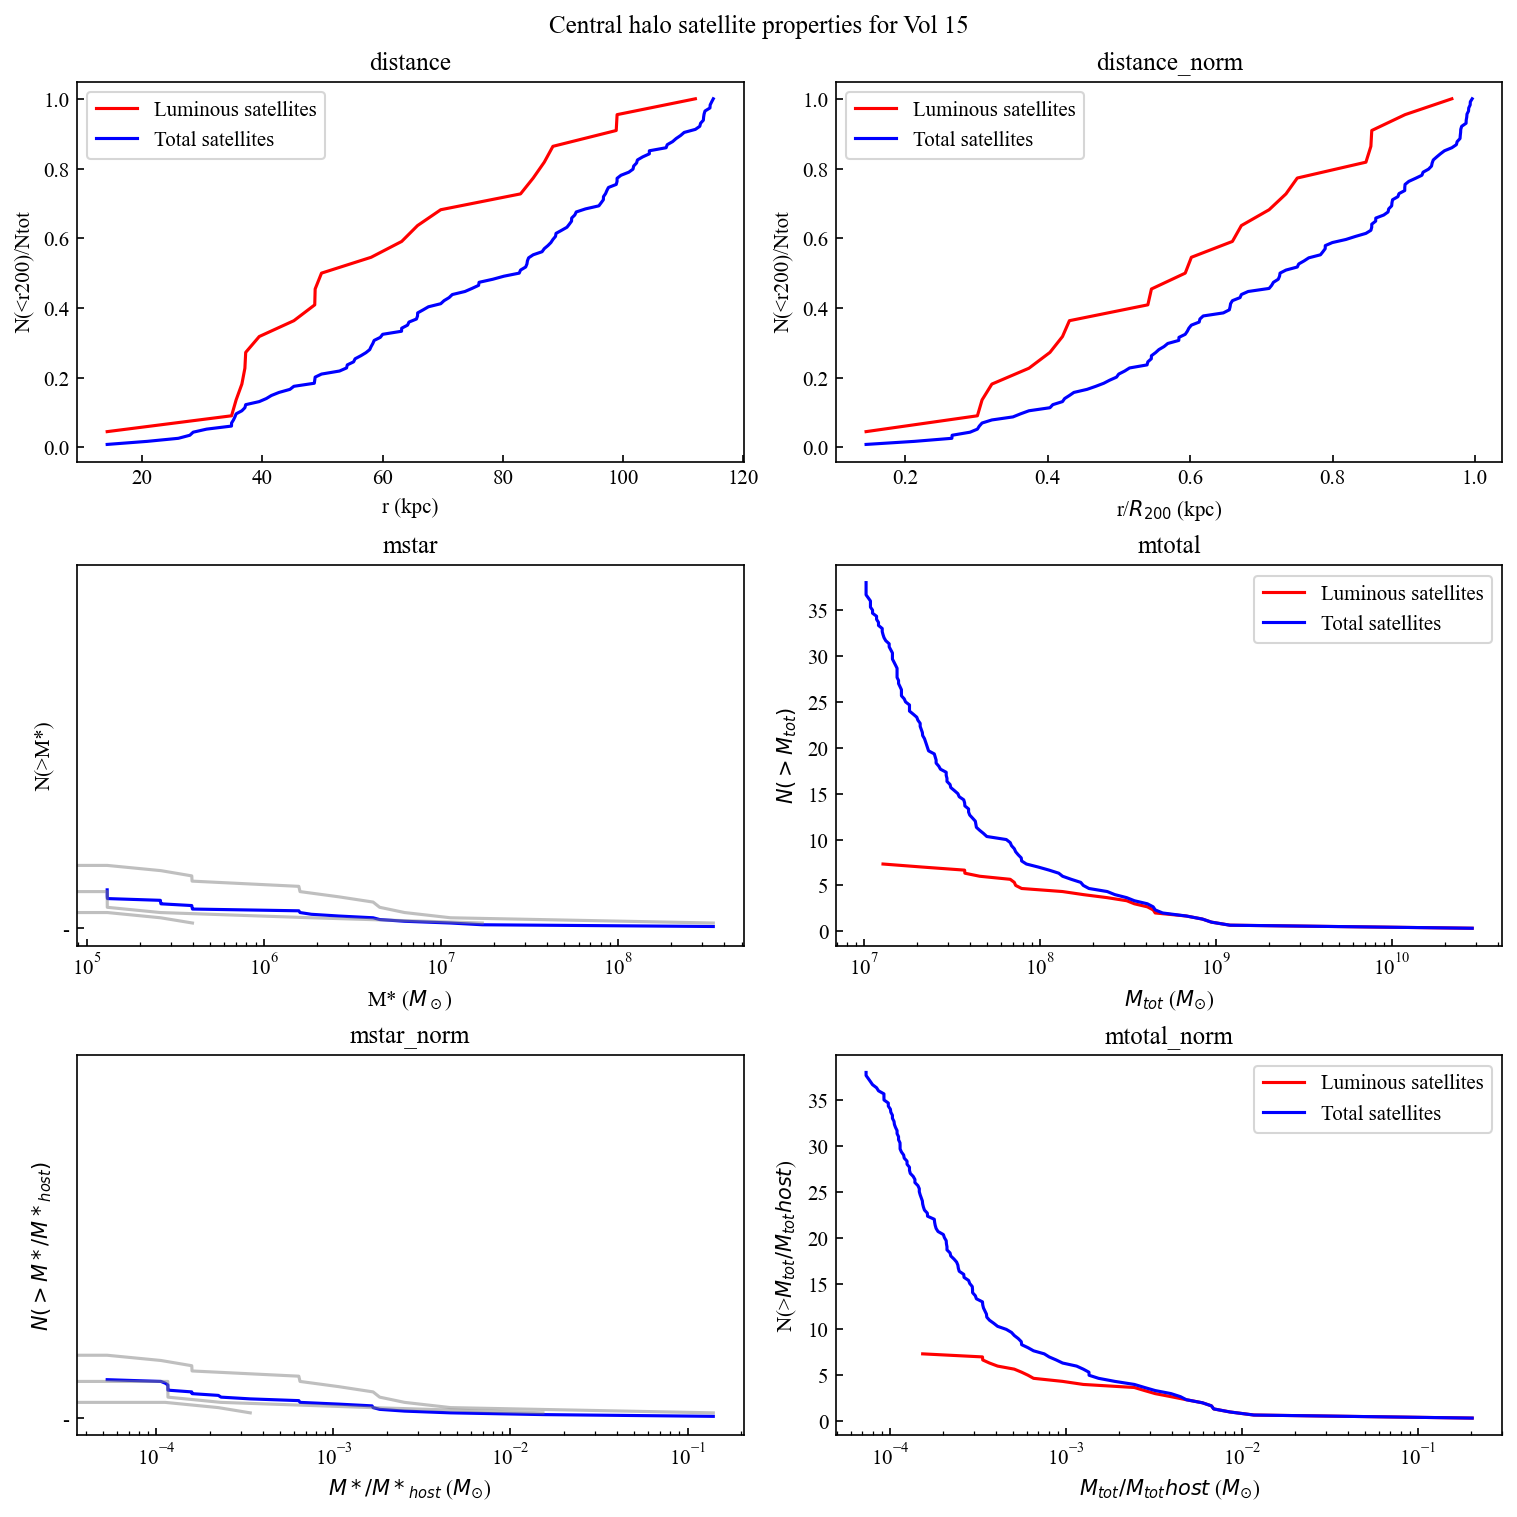

In [25]:
vol15_plotsim.lum_nonlum_number_plots()
#vol15_plotsim.smhm_centralhalos()

C:\Users\prera\AppData\Local\Temp\ipykernel_13144\1123357804.py:258: RuntimeWarning: divide by zero encountered in log10
  axs[0].hist(np.log10(np.ma.array(self.main_df['Host Mtot'])))
C:\Users\prera\AppData\Local\Temp\ipykernel_13144\1123357804.py:259: RuntimeWarning: divide by zero encountered in log10
  axs[1].hist(np.log10(np.ma.array(self.main_df['Host M*'])))
C:\Users\prera\AppData\Local\Temp\ipykernel_13144\1123357804.py:268: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
C:\Users\prera\AppData\Local\Temp\ipykernel_13144\1123357804.py:254: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


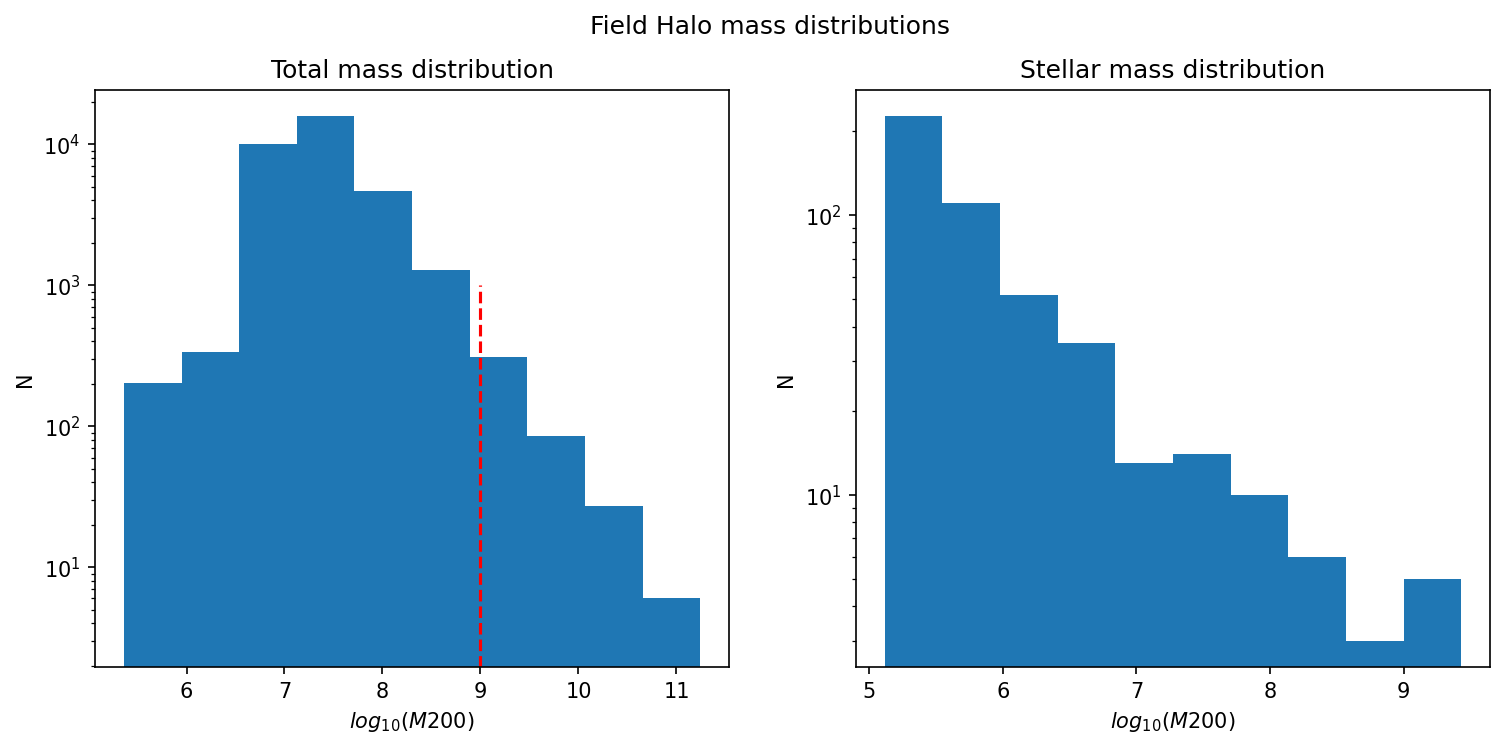

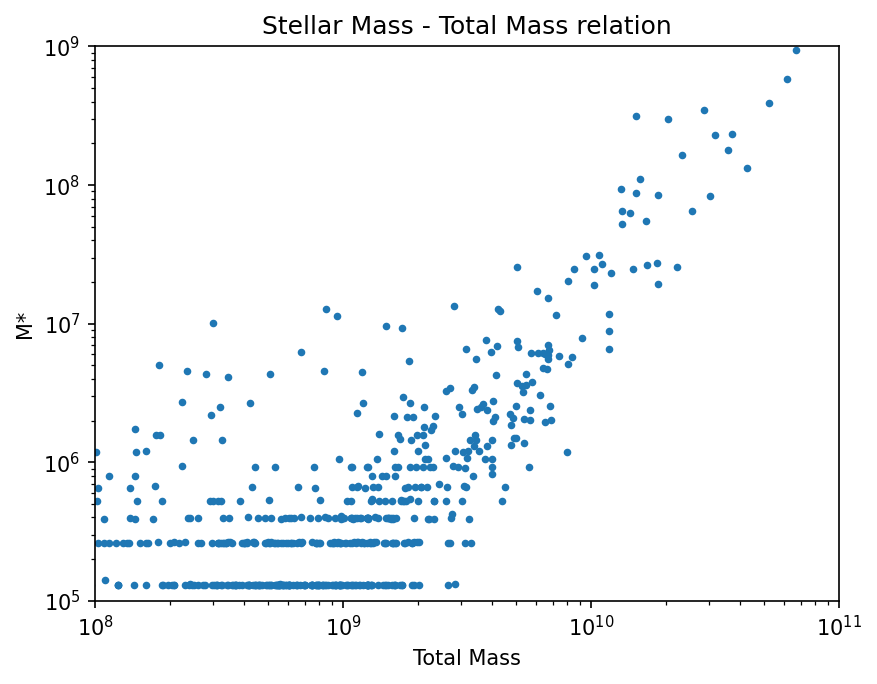

In [27]:
vol15_plotsim.plotFieldHaloMassDist()
vol15_plotsim.plotStellarMassHaloMass_all()

C:\Users\prera\AppData\Local\Temp\ipykernel_13144\2891400660.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


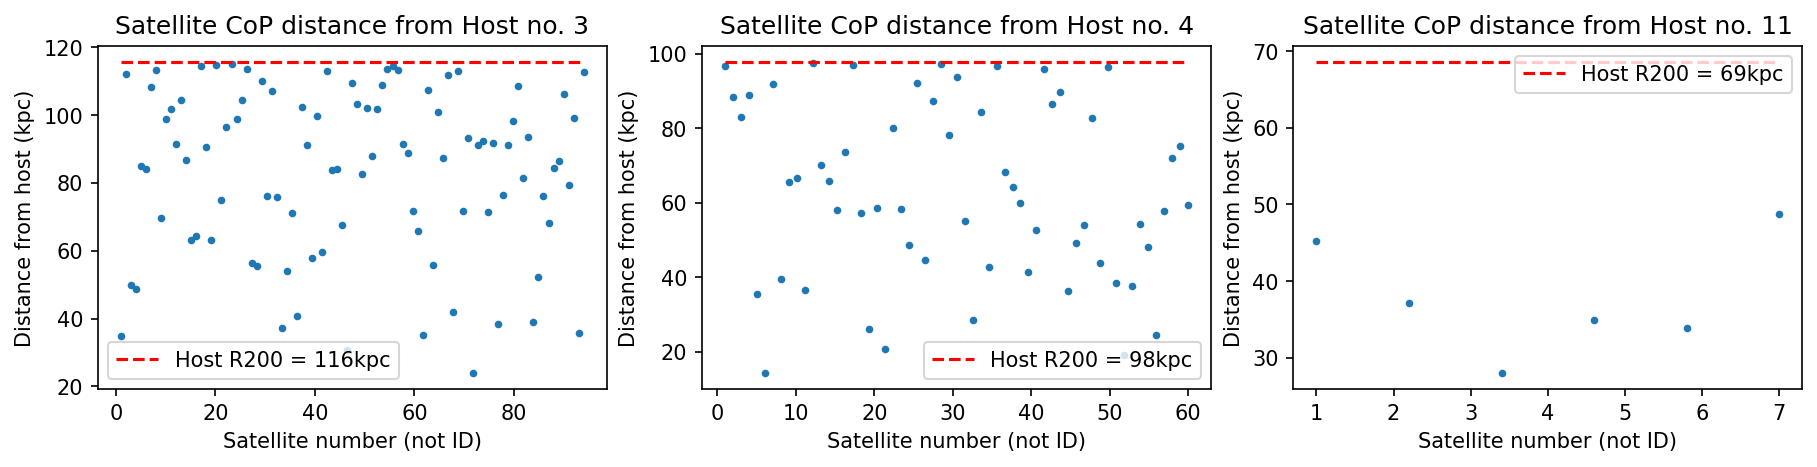

In [28]:
fig, ax = plt.subplots(1, len(vol15_df['Host ID']), figsize = (4*len(vol15_df['Host ID']), len(vol15_df['Host ID'])), dpi=150, constrained_layout=True)
ax_flat = ax.flatten()
central_centers = np.array(vol15_df['Host CoM'])
for i, host_center in enumerate(central_centers):
    sat_centers = np.array(vol15_df['Sat CoM'].iloc[i])
    distances = np.array([np.linalg.norm(sat-host_center) for sat in sat_centers])*1000 #in kpc
    x = np.linspace(1, len(distances)+1, len(distances)) 
    ax_flat[i].scatter(x, distances, s = 7)
    r200 = vol15_df['Host R200'].iloc[i]
    ax_flat[i].hlines(r200, min(x), max(x), 'r', '--', label = f'Host R200 = {r200:.0f}kpc')
    ax_flat[i].set_xlabel('Satellite number (not ID)')
    ax_flat[i].set_ylabel('Distance from host (kpc)')
    host_id = vol15_df['Host ID'].iloc[i]
    ax_flat[i].set_title(f'Satellite CoP distance from Host no. {host_id}')
    ax_flat[i].legend()
fig.show()

In [29]:
#load in median data from csv file:
median_data = pd.read_csv('medianDataset.csv', header=None)

In [30]:
csv_file = 'data/volume_number_20.csv'
vol20_plotsim = SimToolsPlotting(csv_file)
vol20_df = vol20_plotsim.getCentralHalos()


C:\Users\prera\AppData\Local\Temp\ipykernel_13144\1123357804.py:234: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.central_df[col].at[i] = np.array(self.central_df[col].loc[i])[distance_mask].tolist()


C:\Users\prera\AppData\Local\Temp\ipykernel_13144\1123357804.py:562: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


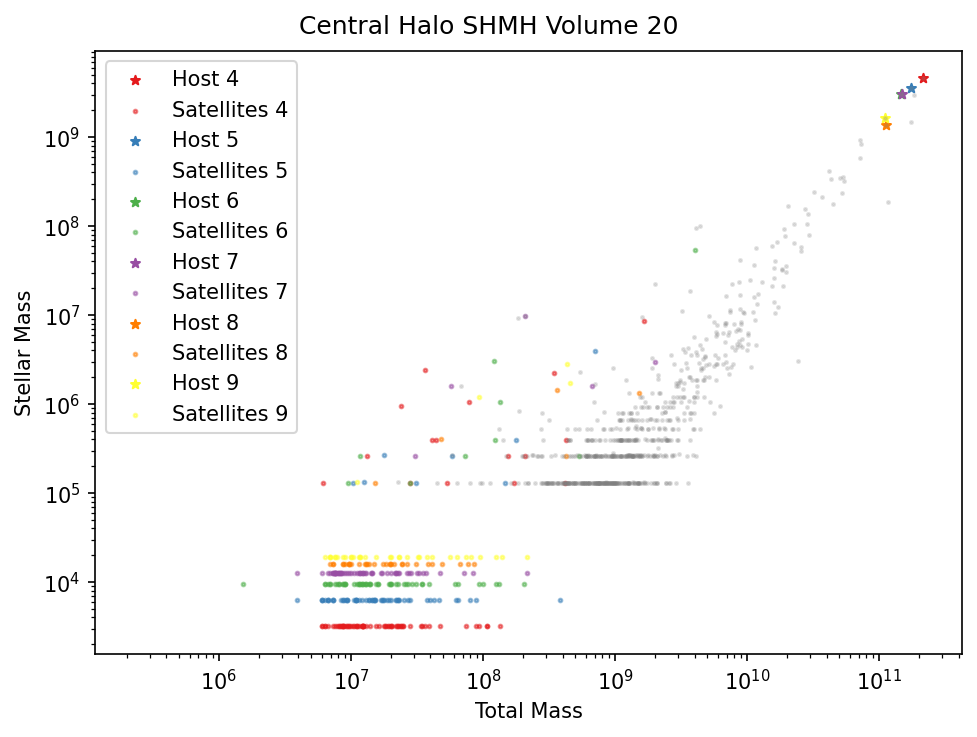

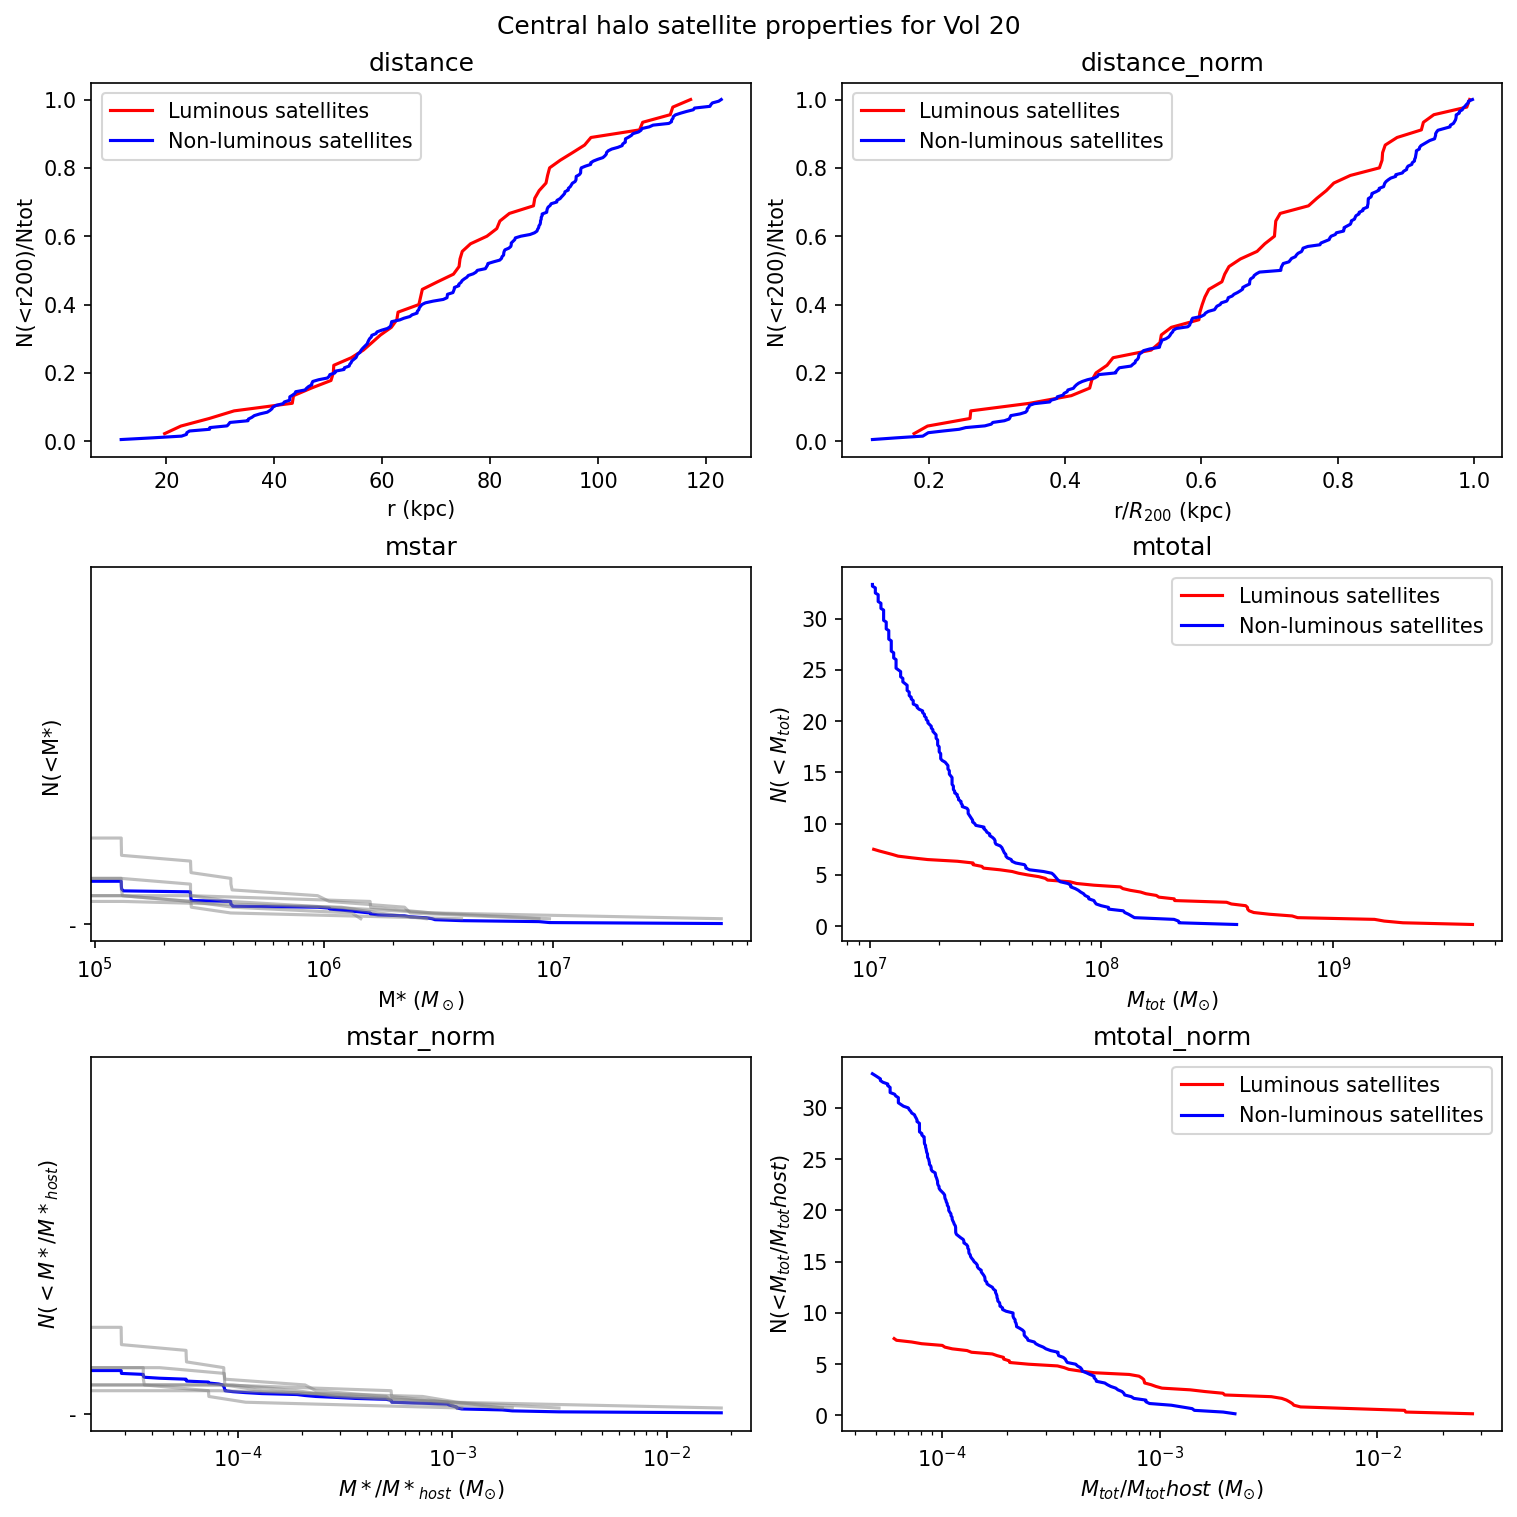

In [31]:
vol20_plotsim.smhm_centralhalos()
vol20_plotsim.lum_nonlum_number_plots()

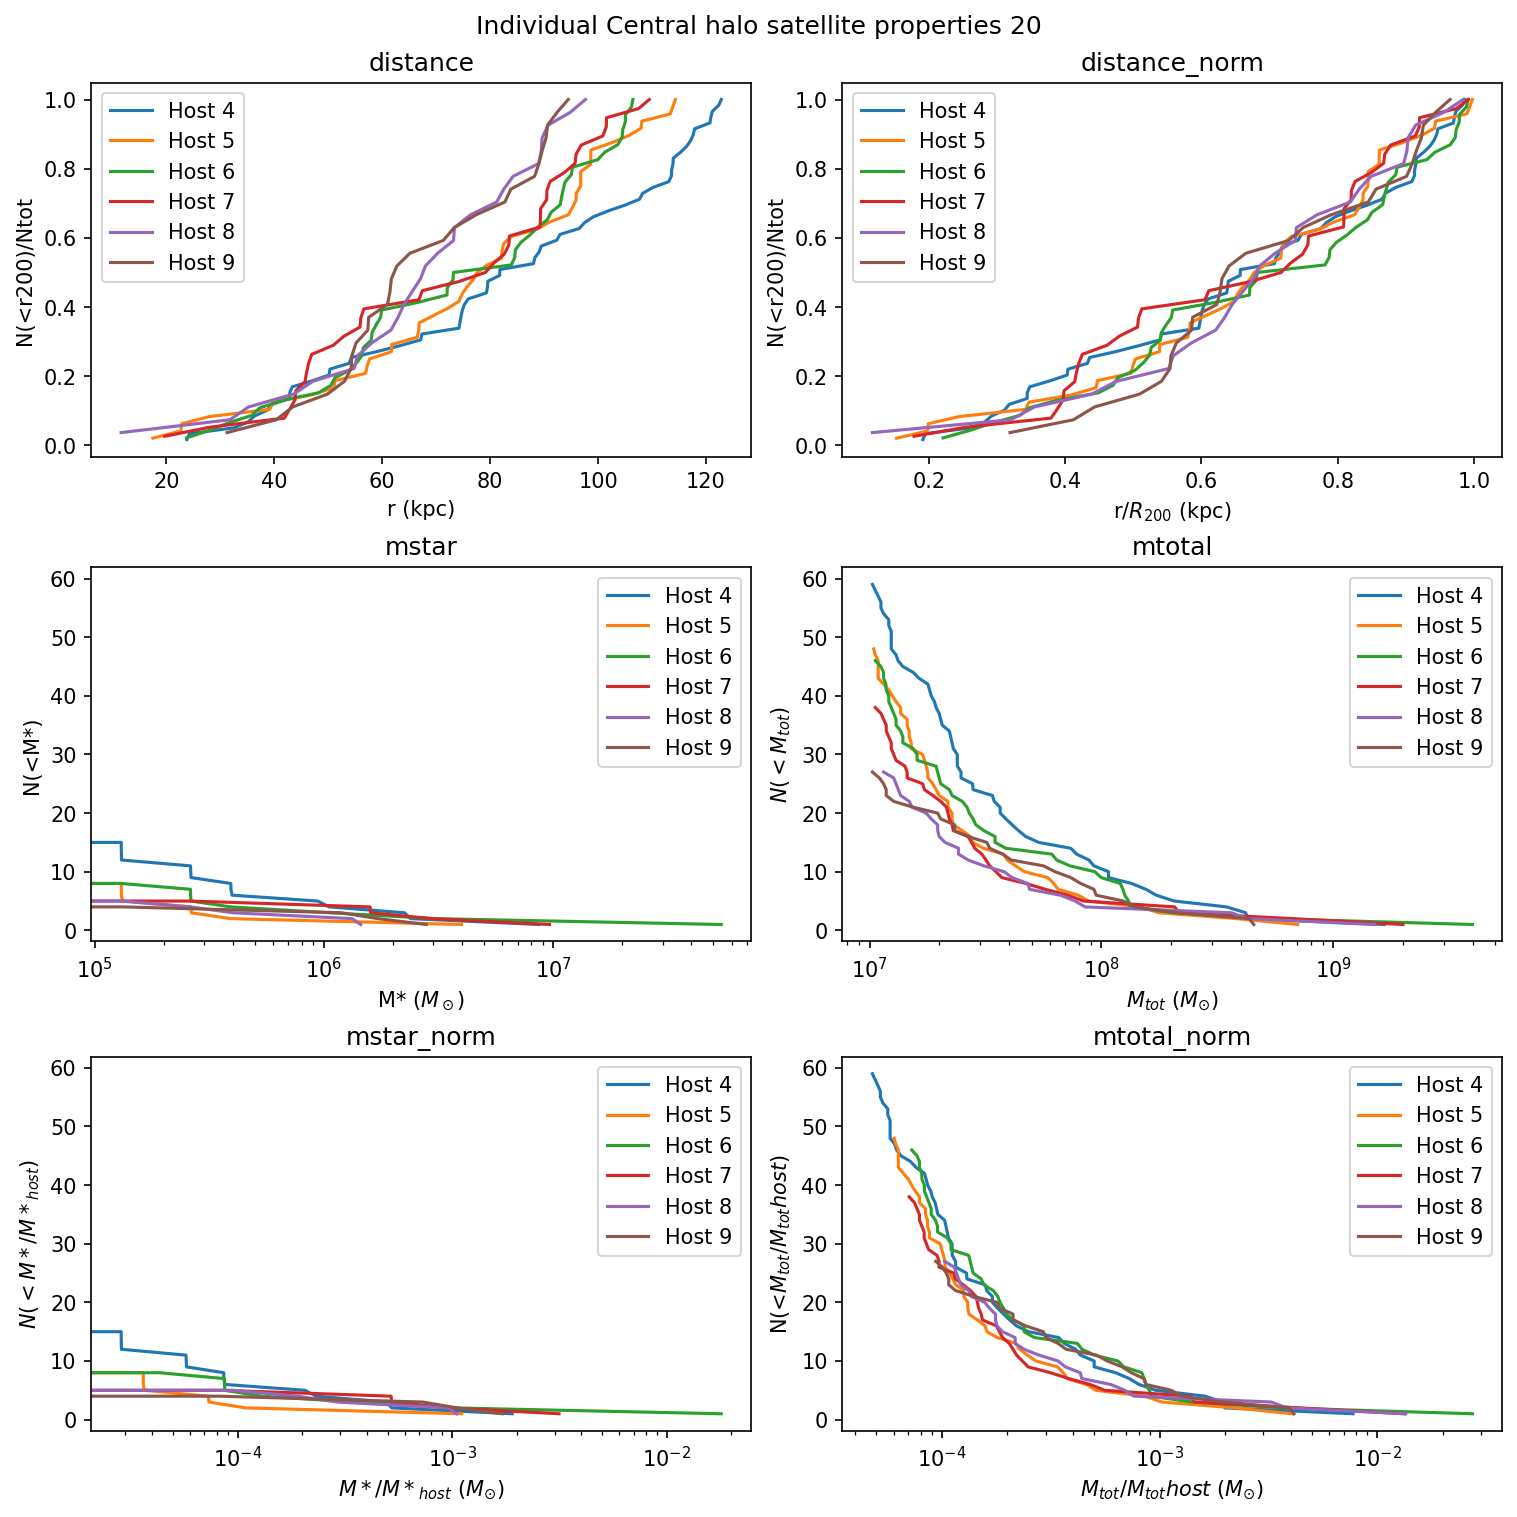

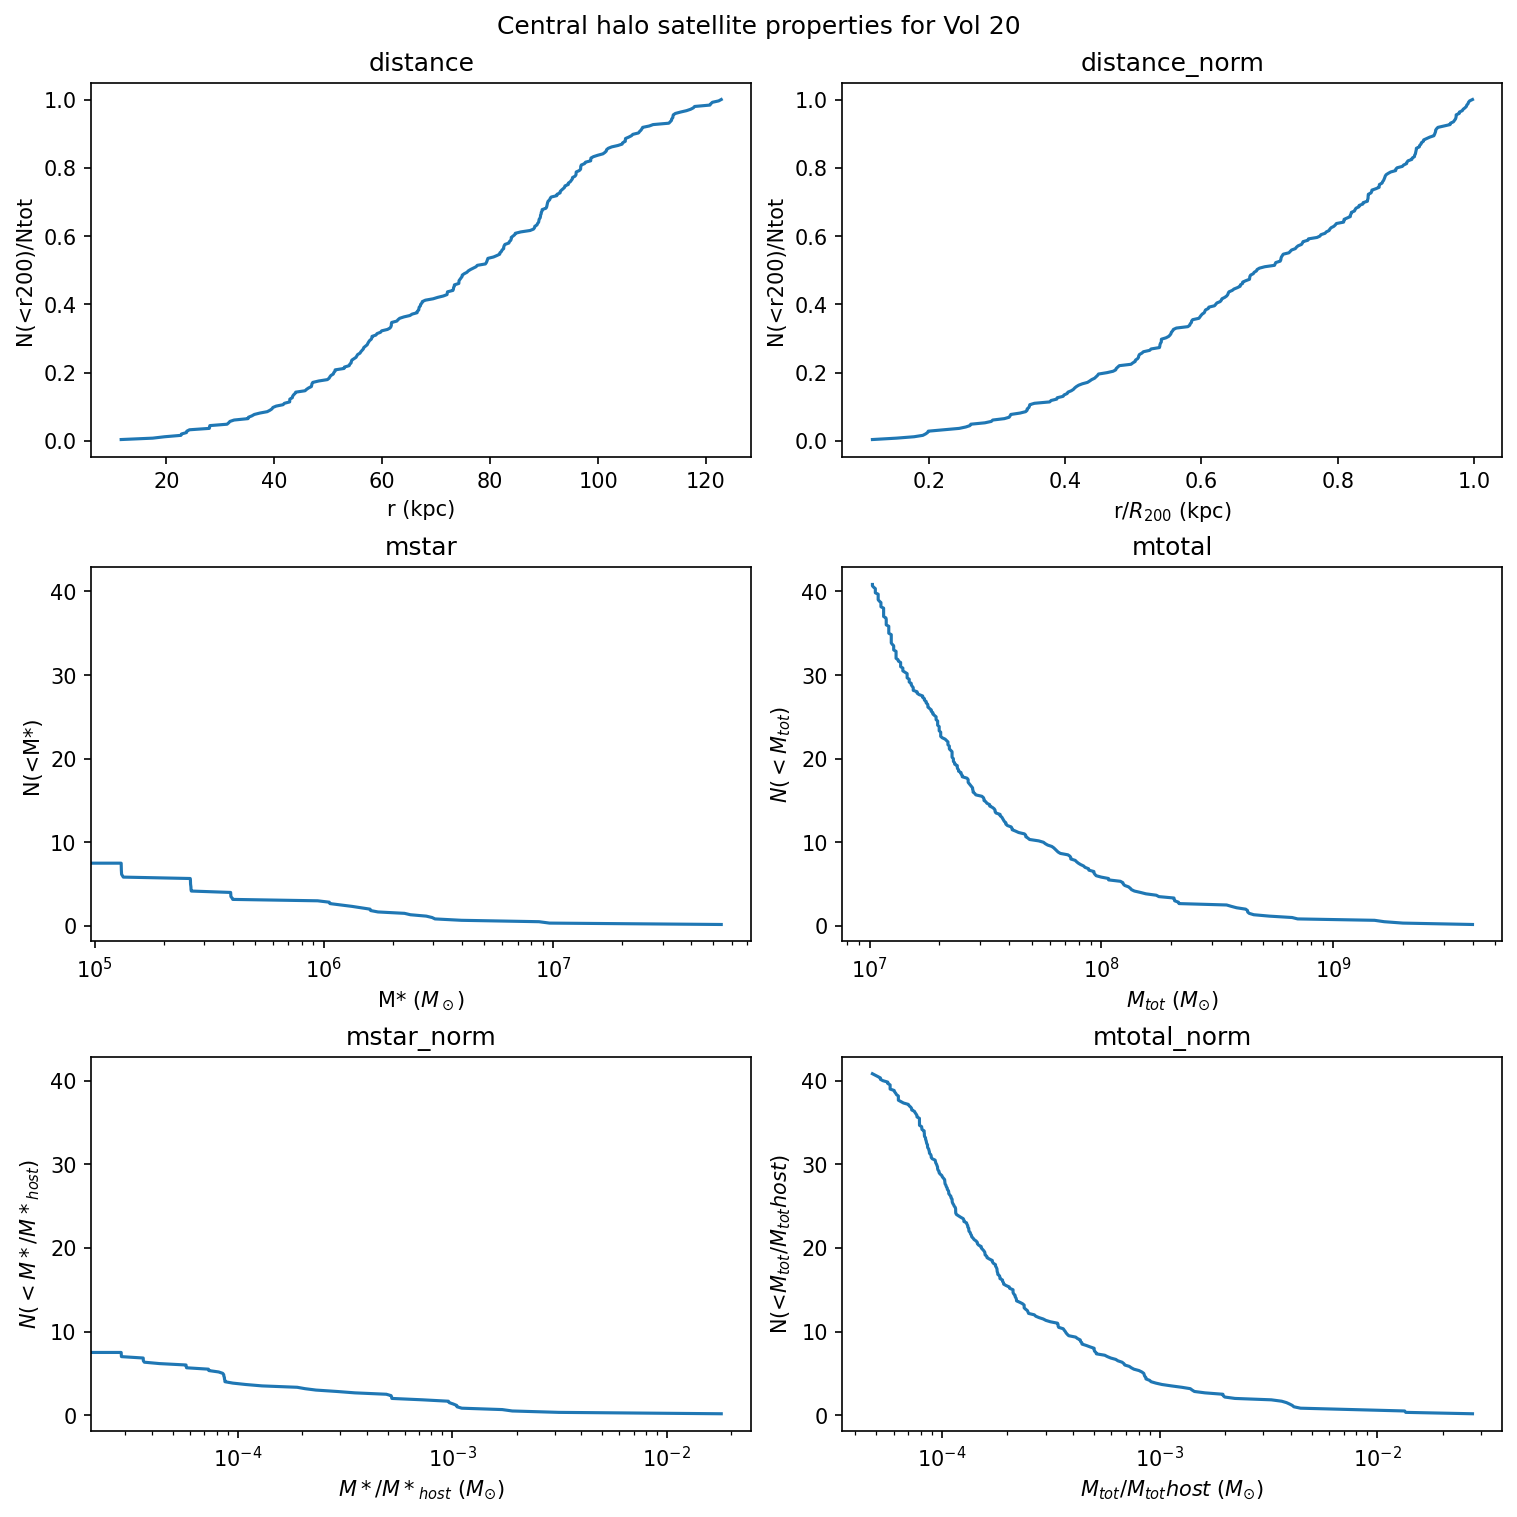

In [32]:
vol20_plotsim.number_plots(mstar_cut=True, mtot_cut=True)
vol20_plotsim.avg_number_plots(mstar_cut=True, mtot_cut=True)

In [33]:
csv_file = 'data/volume_number_25.csv'
vol25_plotsim = SimToolsPlotting(csv_file)
vol25_df = vol25_plotsim.getCentralHalos()

C:\Users\prera\AppData\Local\Temp\ipykernel_13144\1123357804.py:234: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.central_df[col].at[i] = np.array(self.central_df[col].loc[i])[distance_mask].tolist()


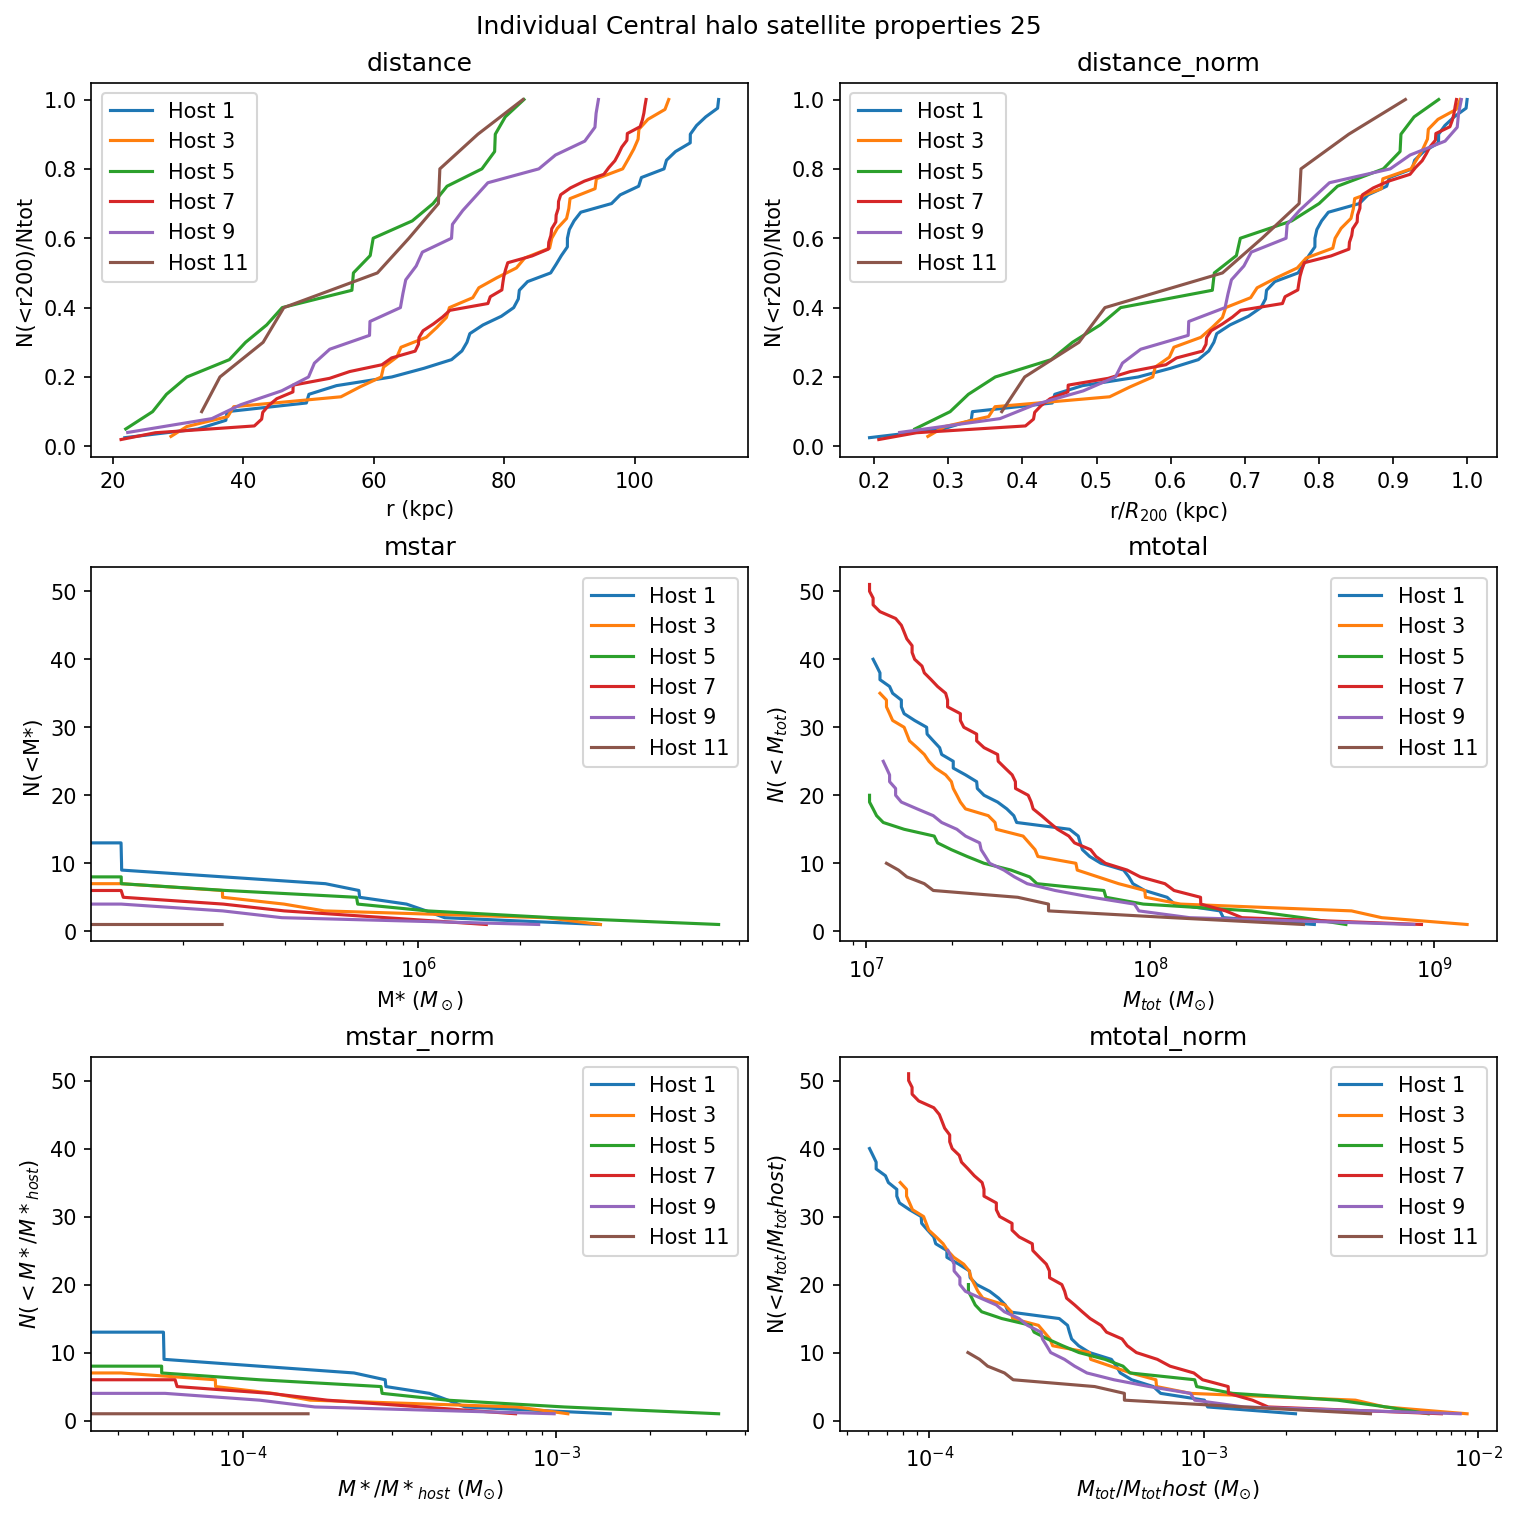

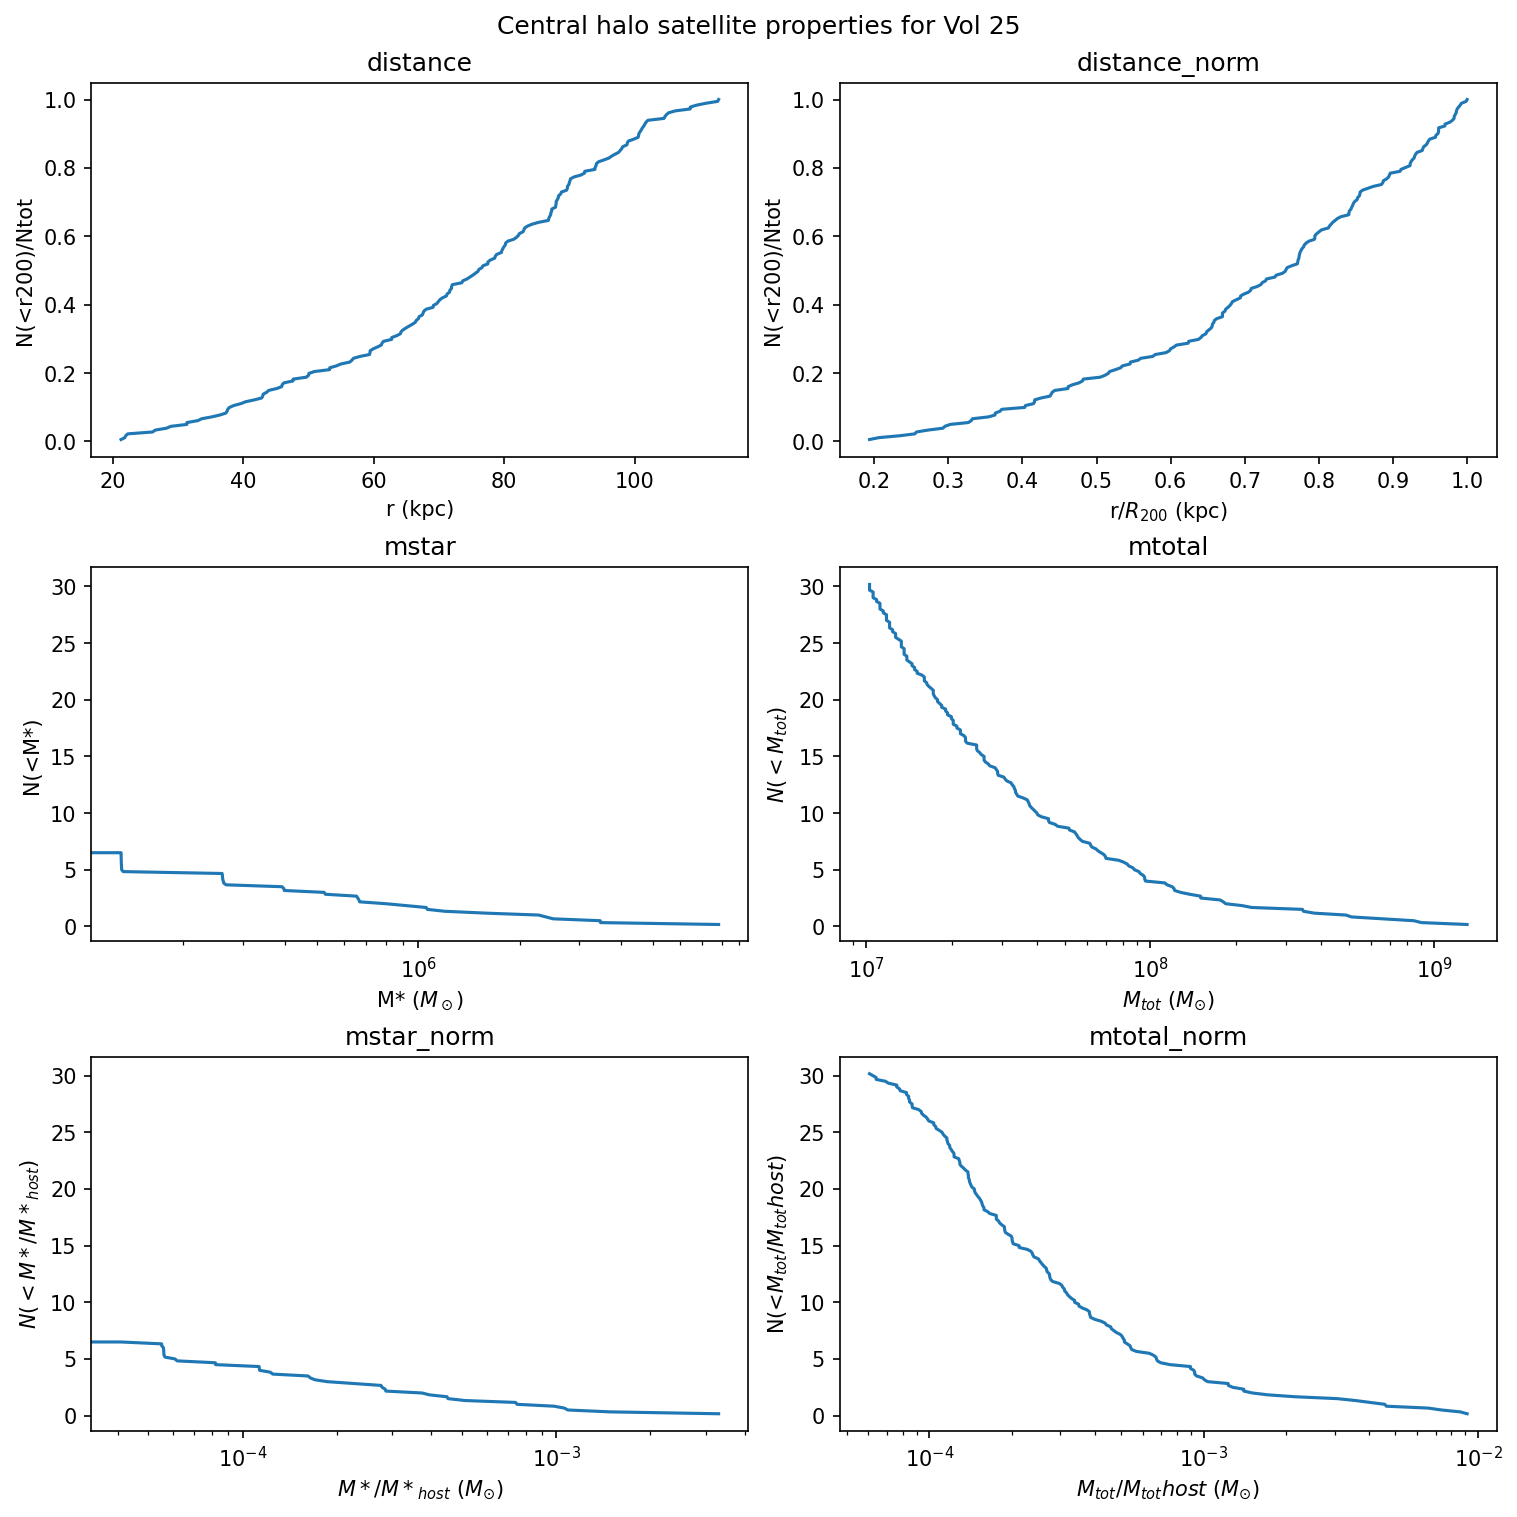

C:\Users\prera\AppData\Local\Temp\ipykernel_13144\1123357804.py:562: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


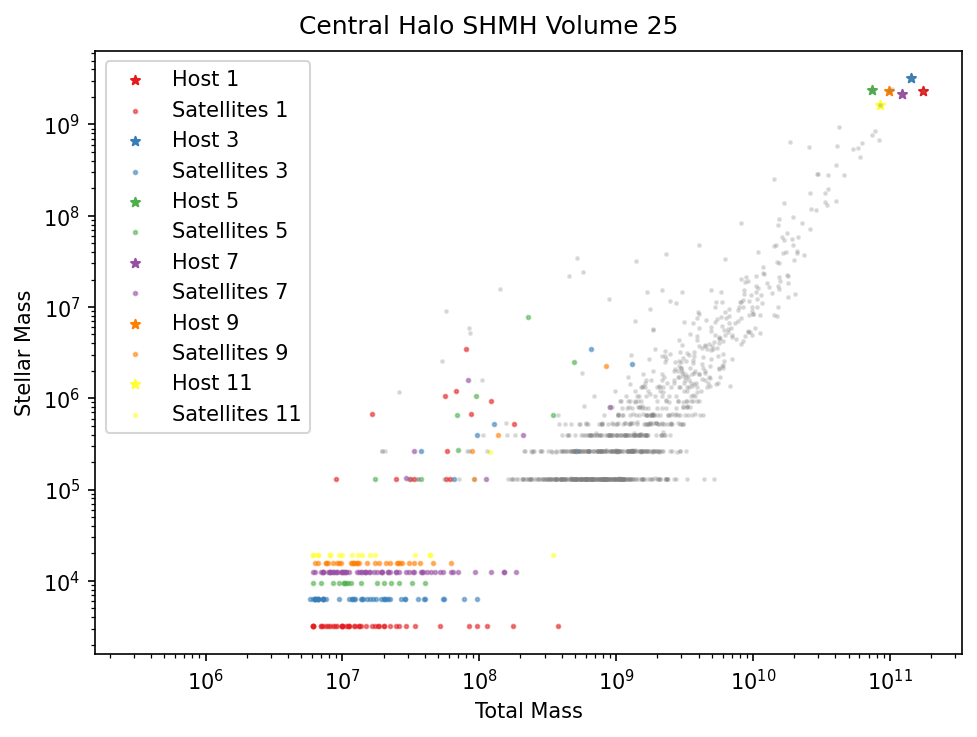

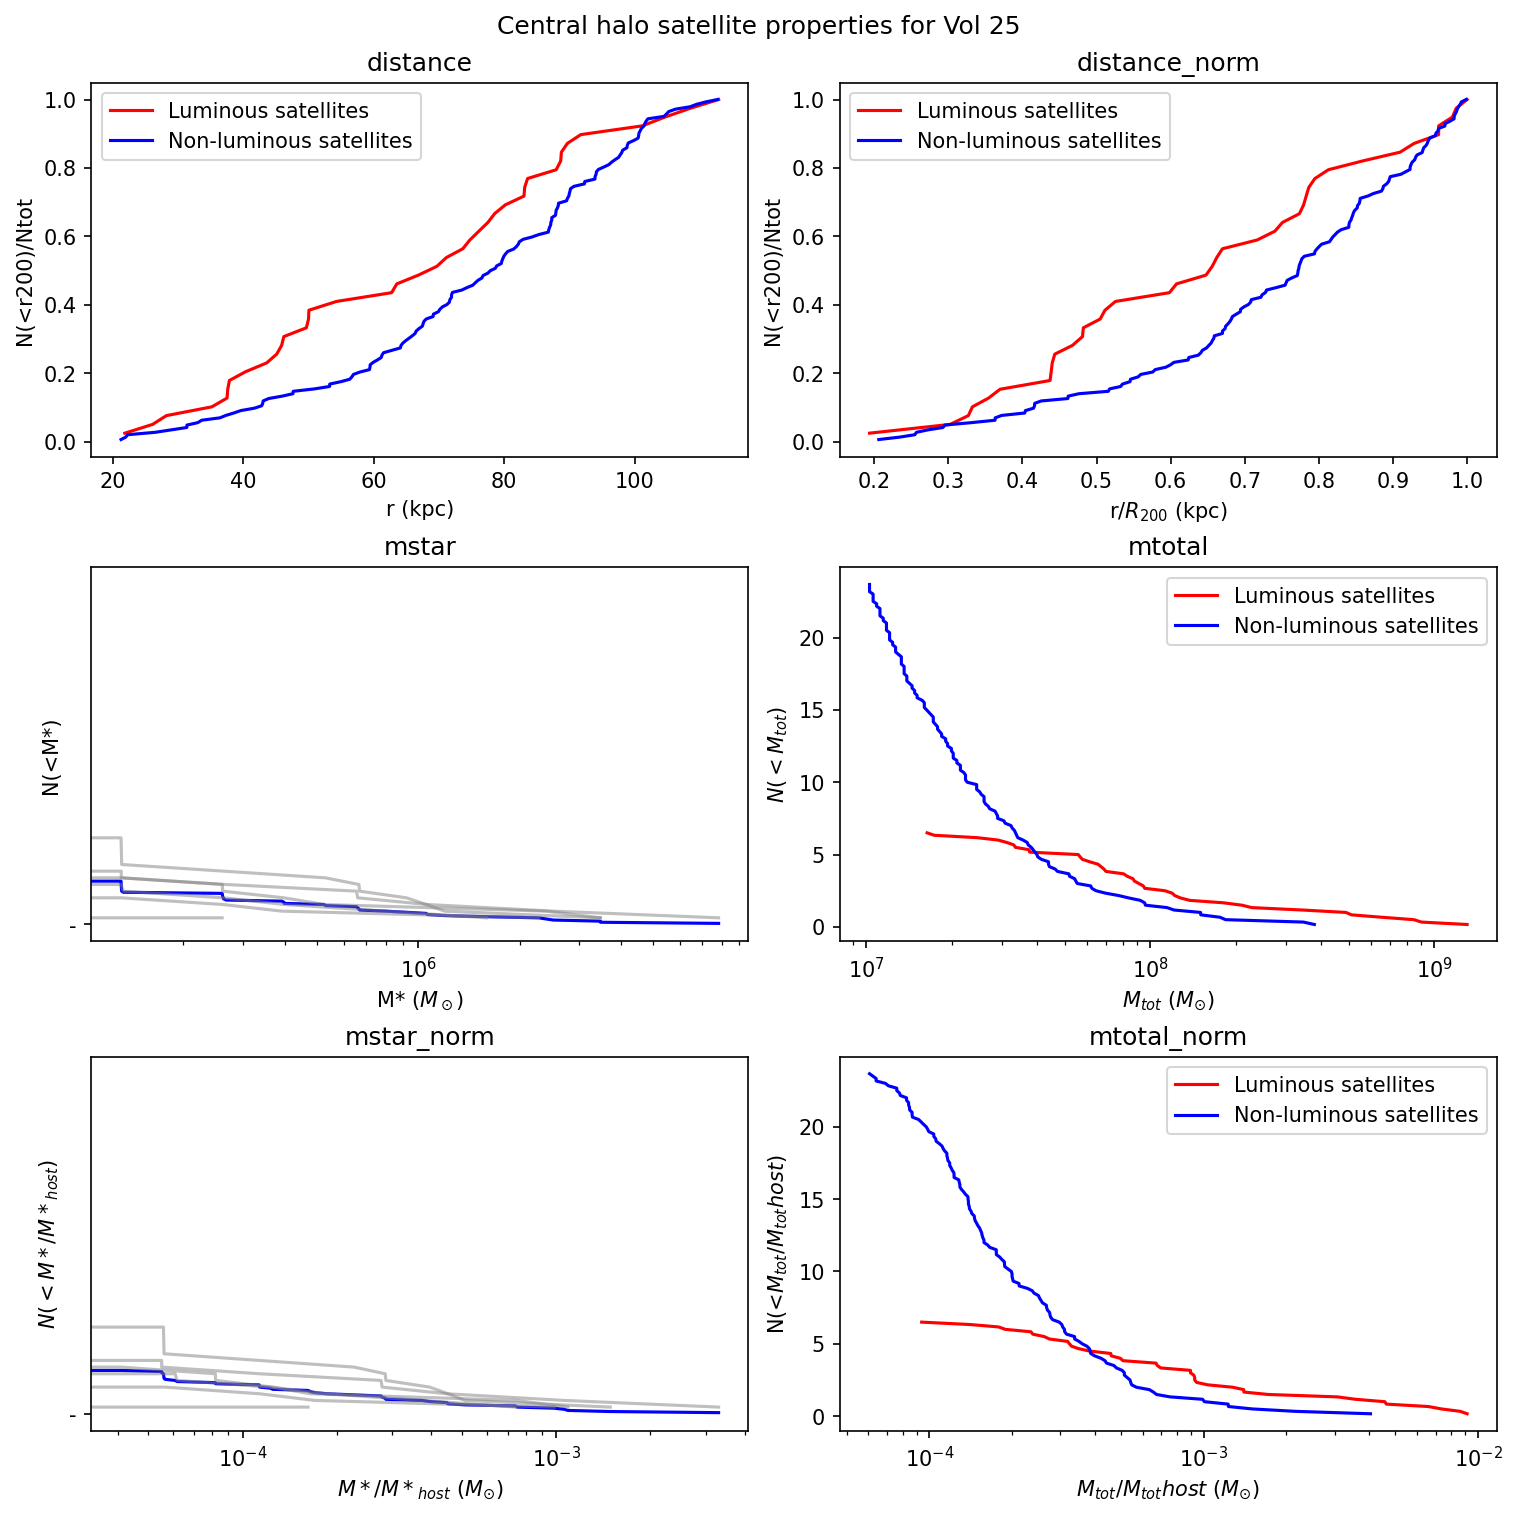

In [34]:
vol25_plotsim.number_plots(mstar_cut=True, mtot_cut=True)
vol25_plotsim.avg_number_plots(mstar_cut=True, mtot_cut=True)
vol25_plotsim.smhm_centralhalos()
vol25_plotsim.lum_nonlum_number_plots()

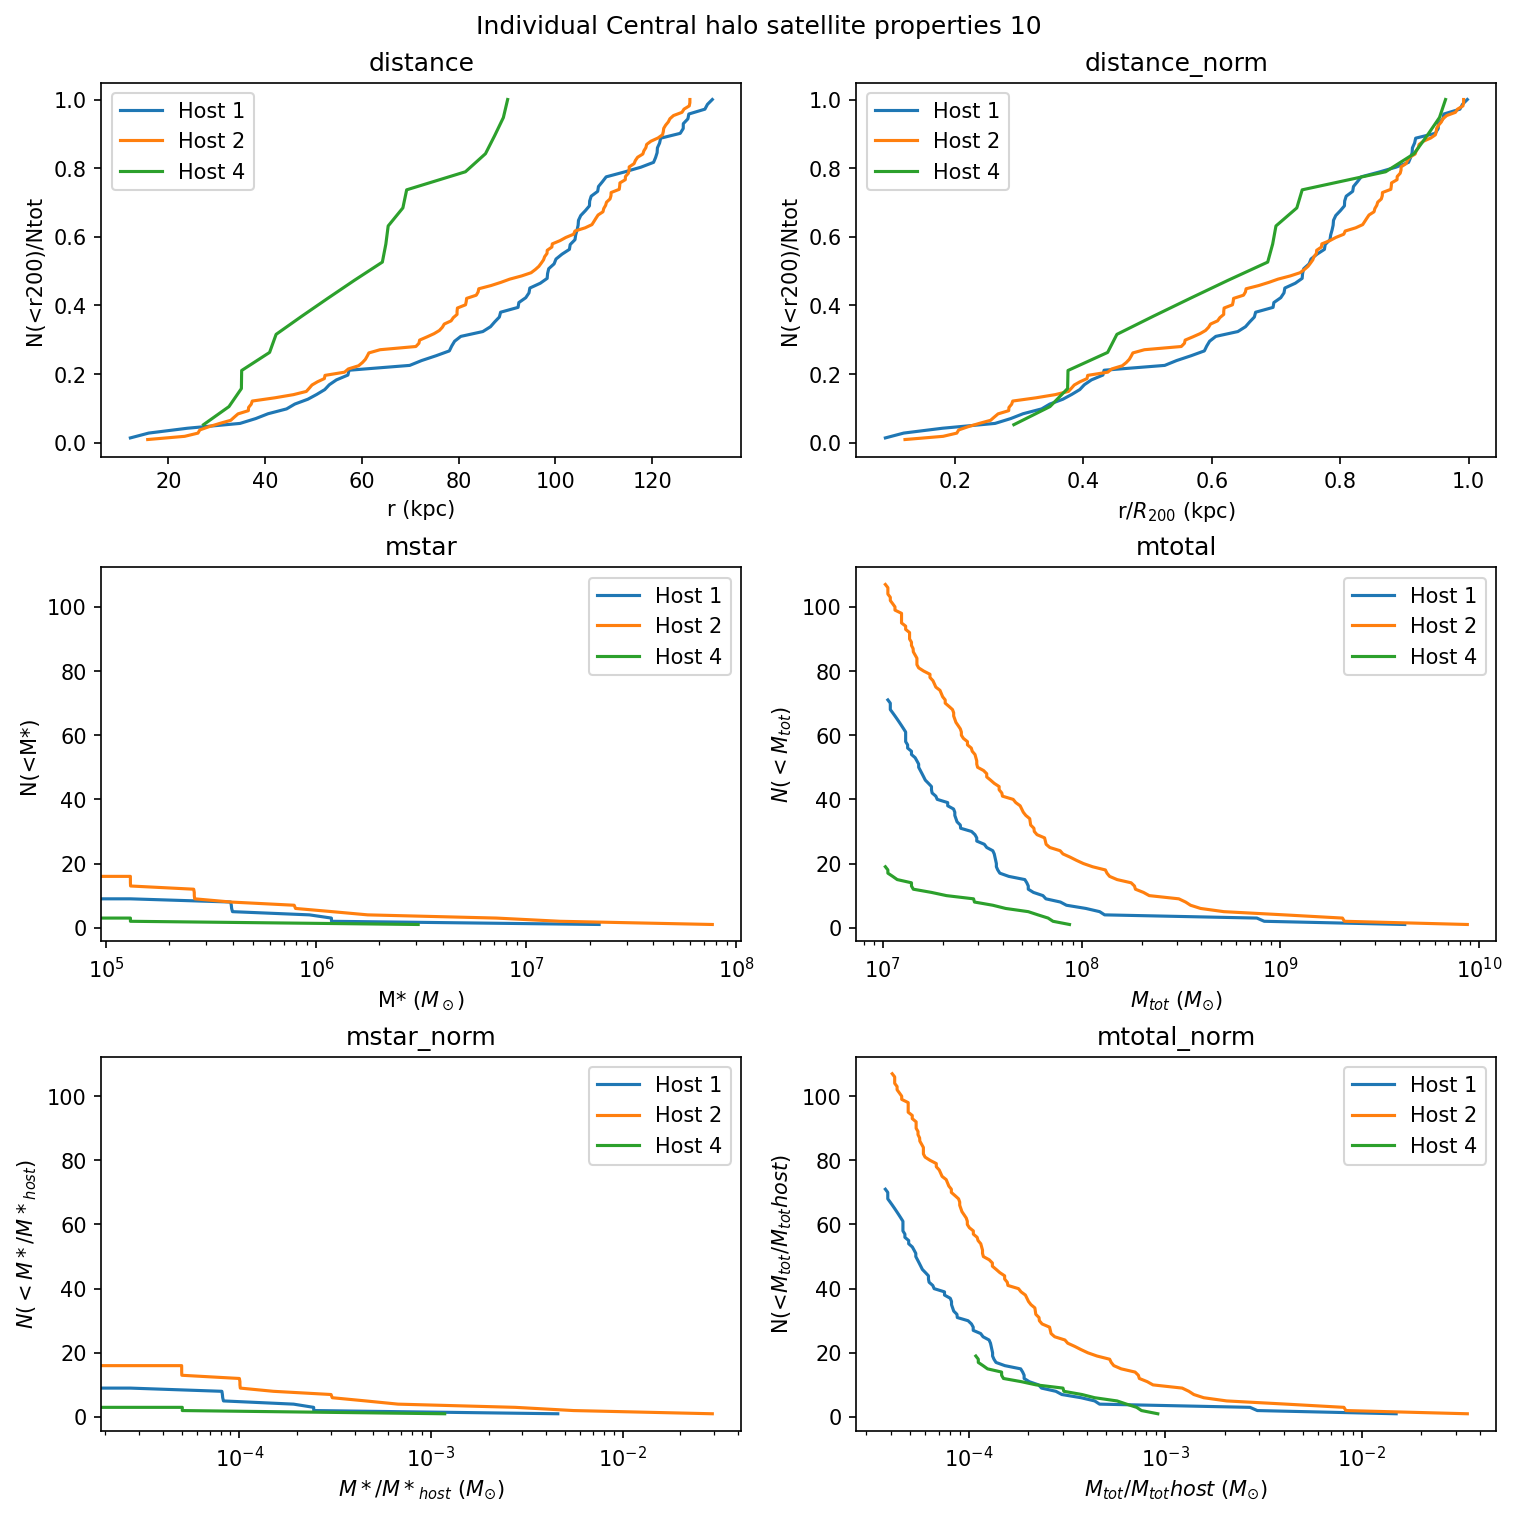

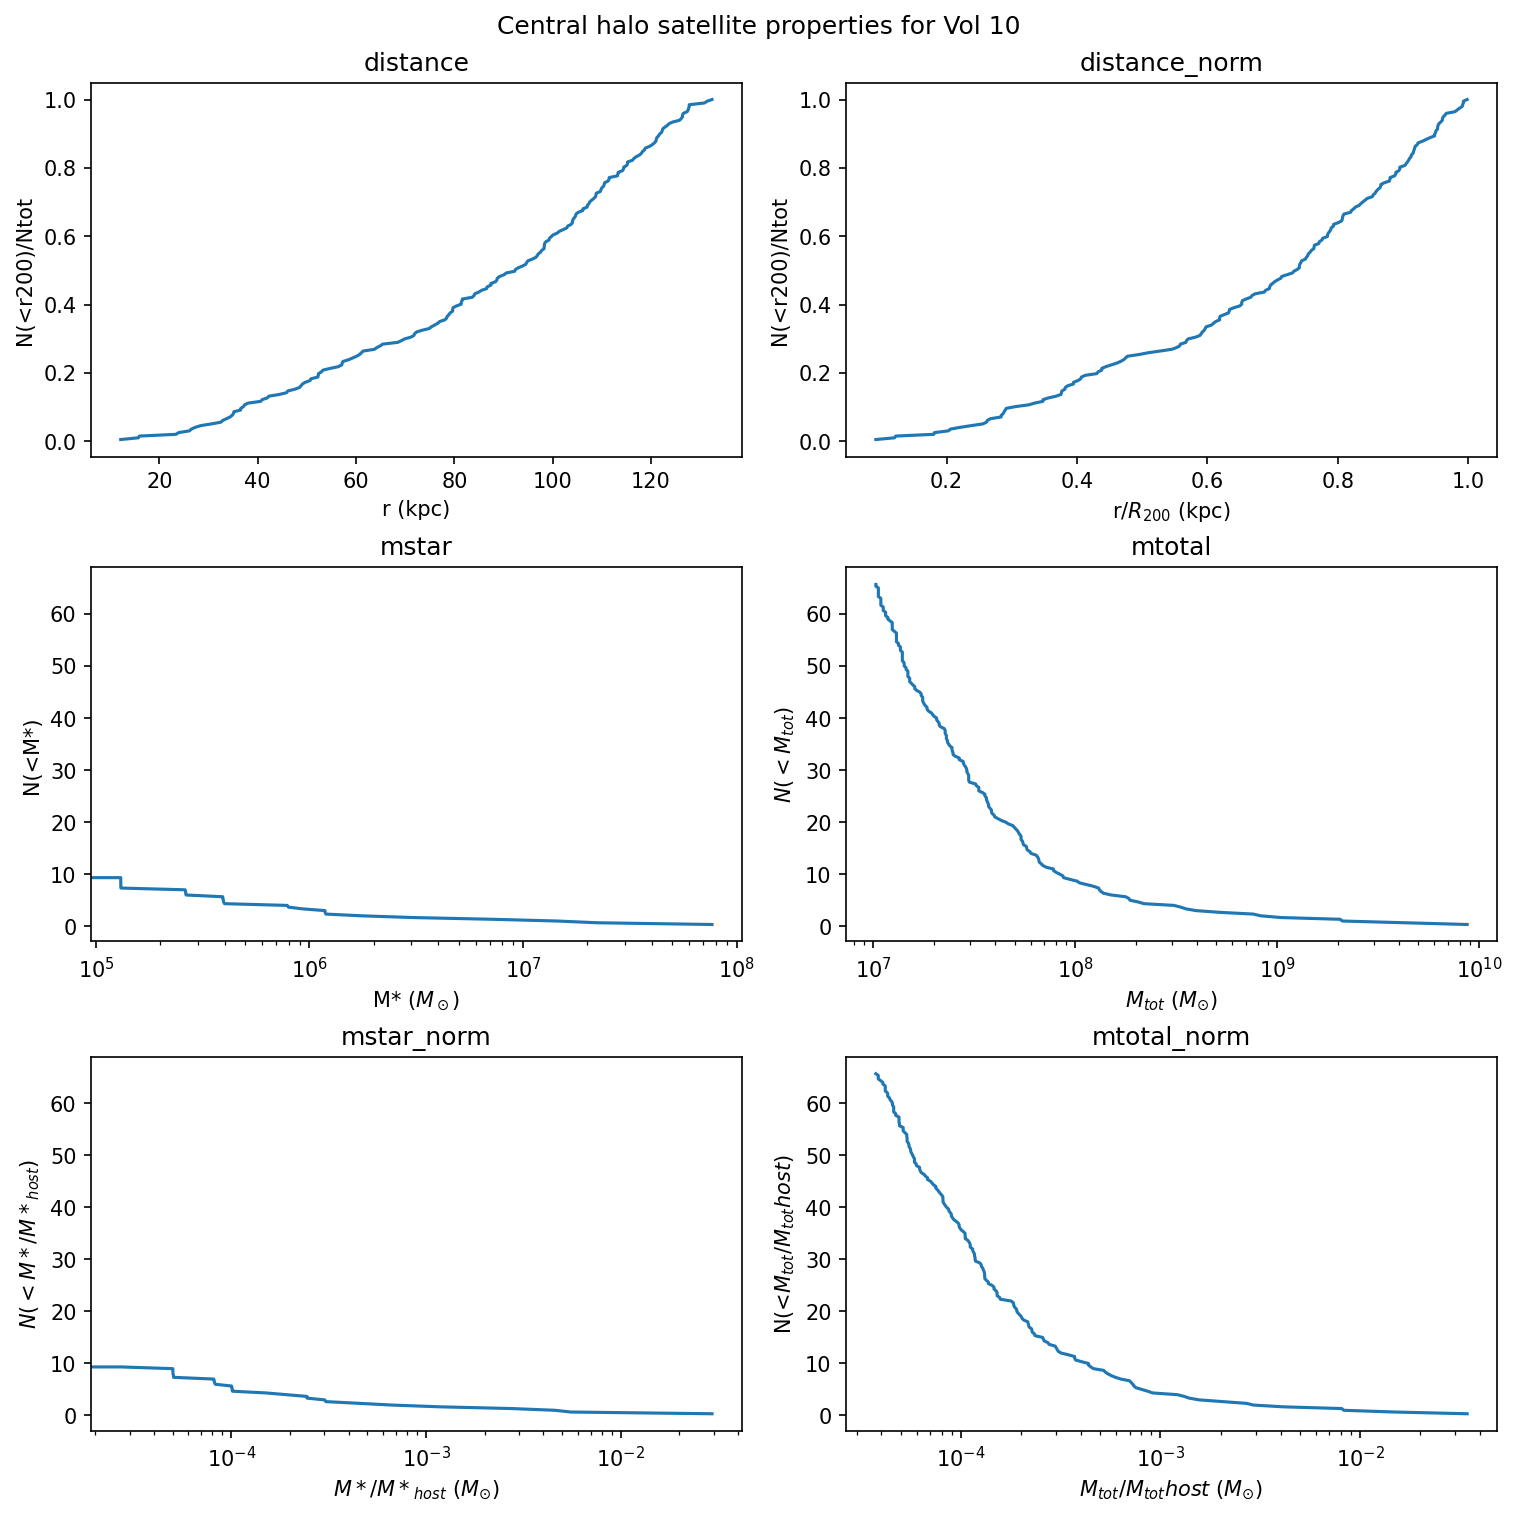

C:\Users\prera\AppData\Local\Temp\ipykernel_13144\1123357804.py:562: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


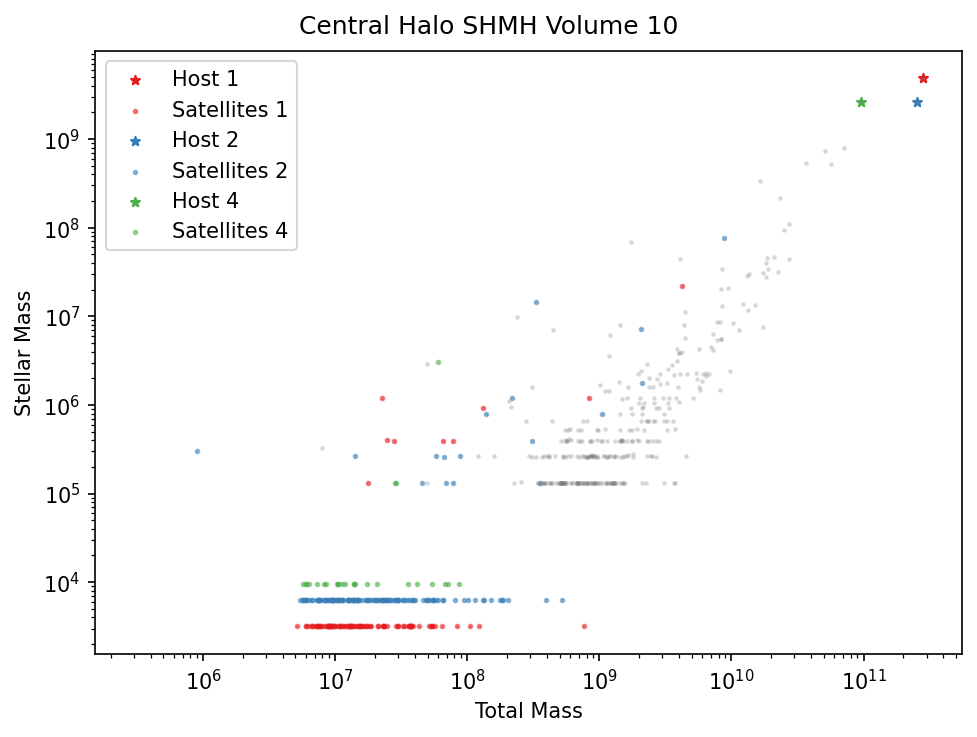

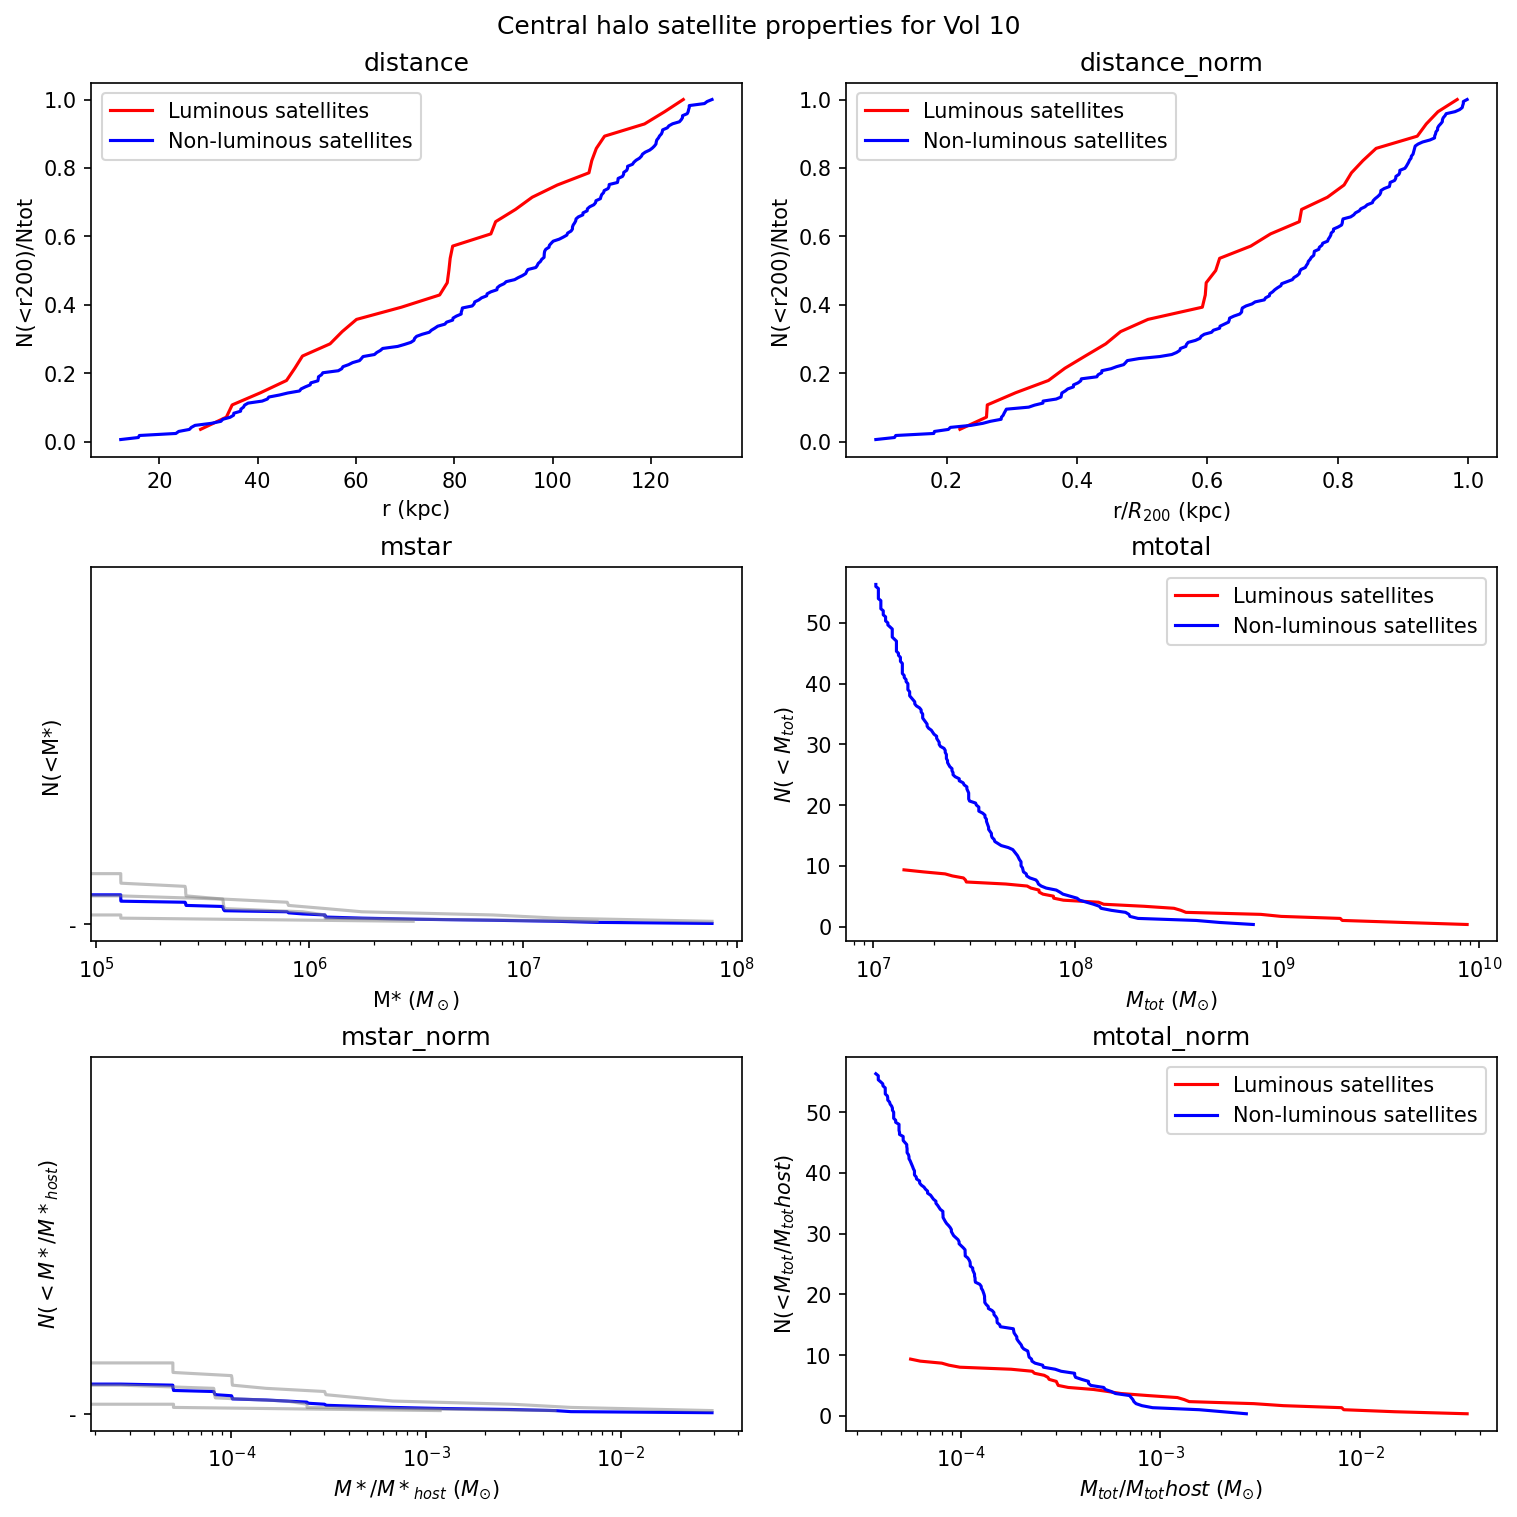

In [36]:
csv_file = 'data/volume_number_10.csv'
vol10_plotsim = SimToolsPlotting(csv_file)
vol10_df = vol10_plotsim.getCentralHalos(dist_from_center=6)
vol10_plotsim.number_plots(mstar_cut=True, mtot_cut=True)
vol10_plotsim.avg_number_plots(mstar_cut=True, mtot_cut=True)
vol10_plotsim.smhm_centralhalos()
vol10_plotsim.lum_nonlum_number_plots()

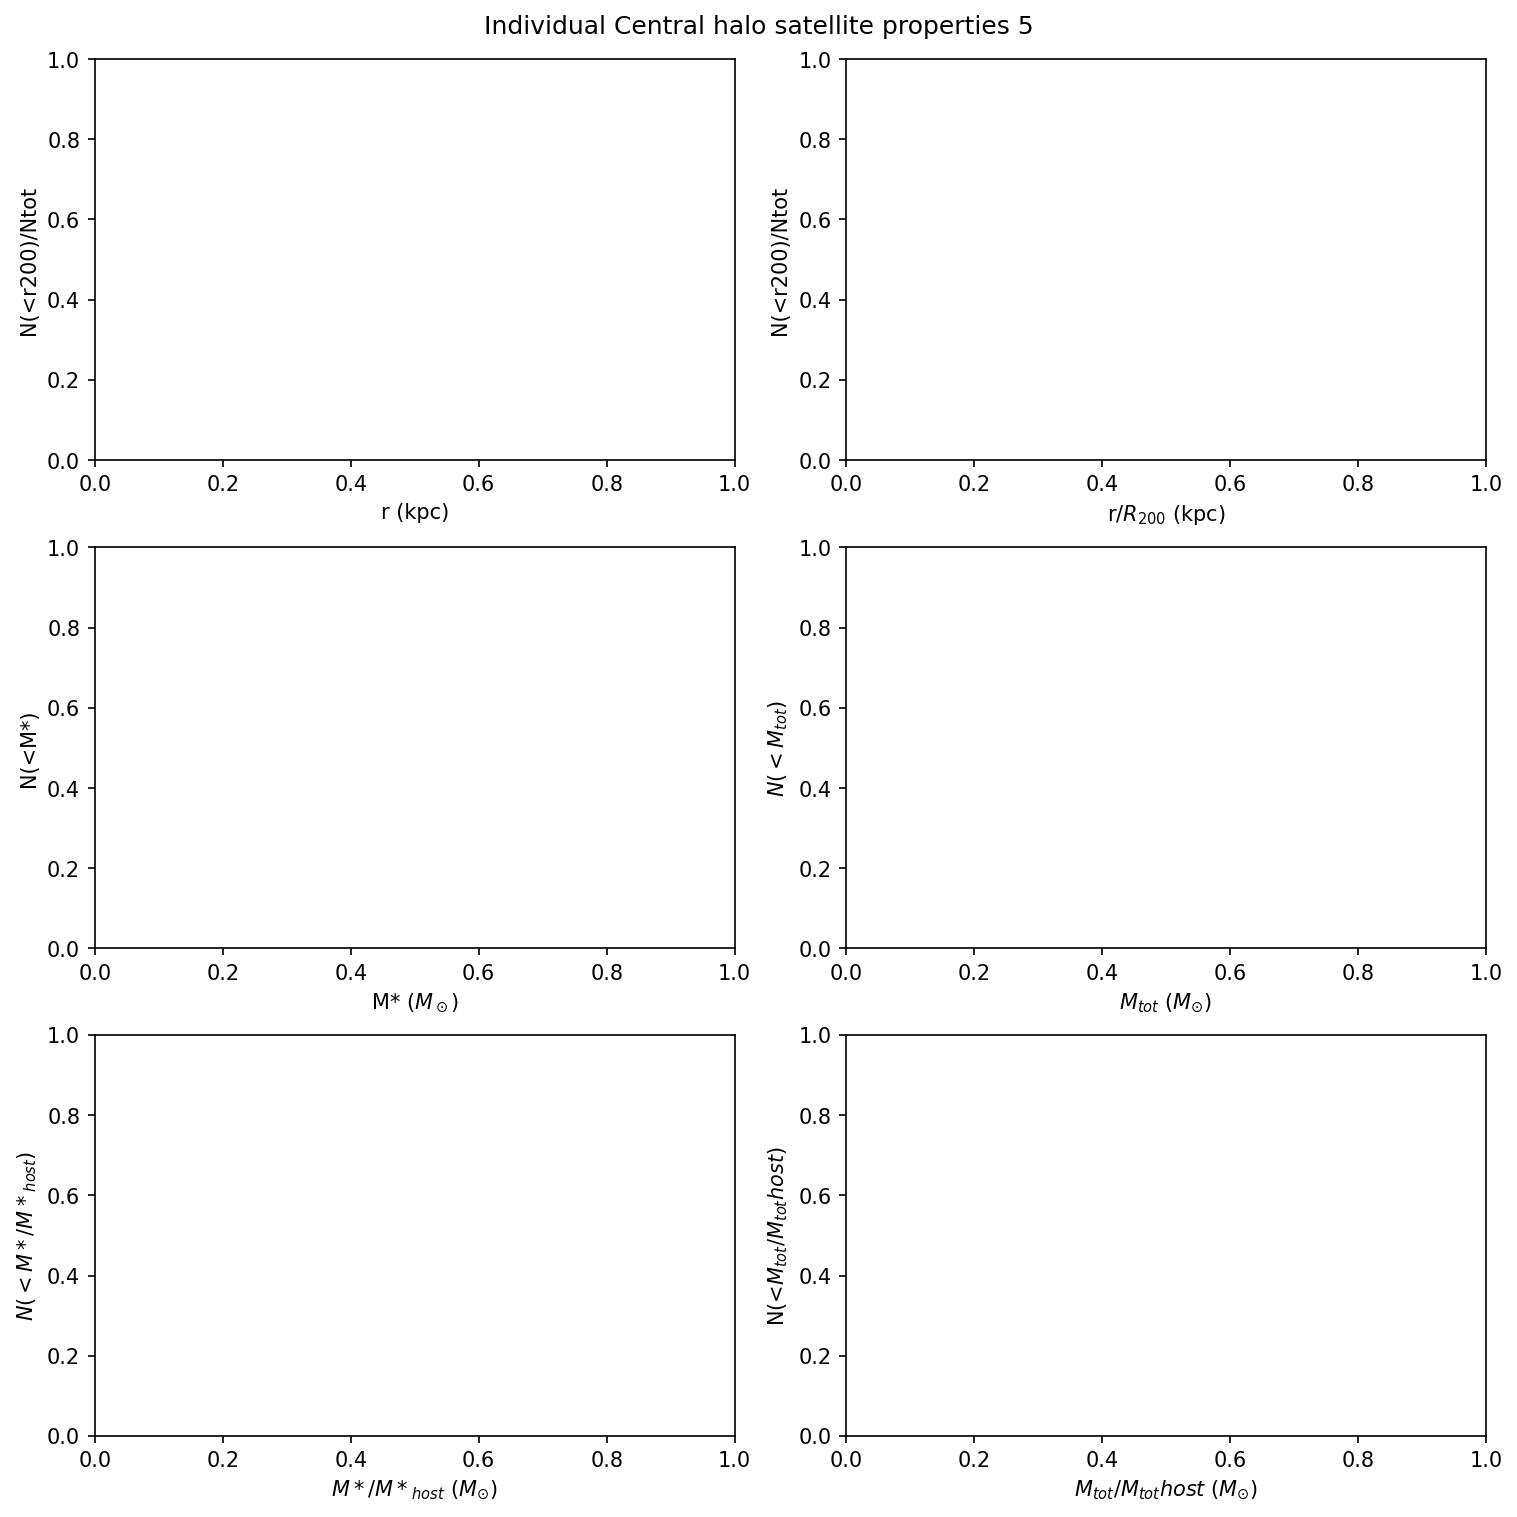

ValueError: need at least one array to concatenate

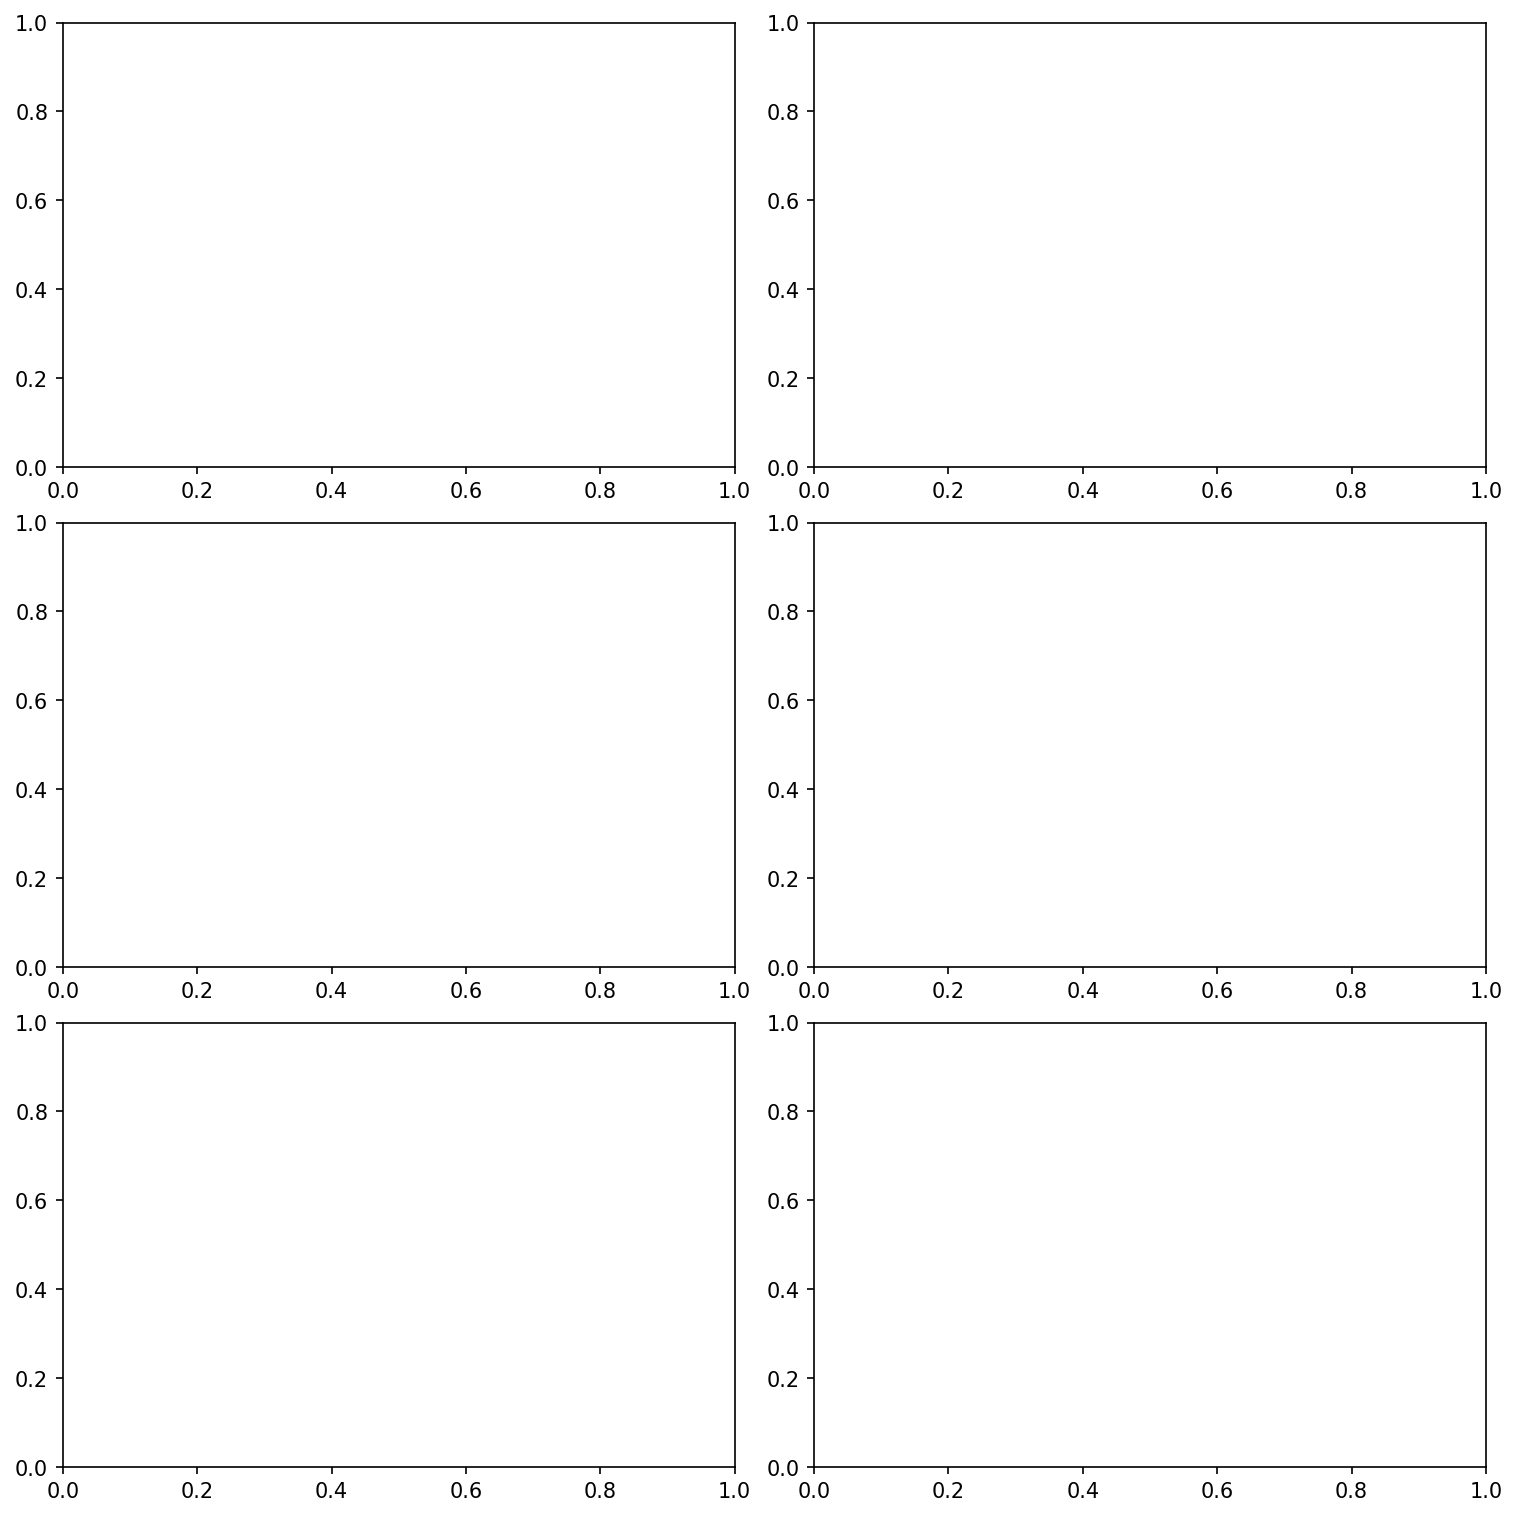

In [37]:
csv_file = 'data/volume_number_05.csv'
vol05_plotsim = SimToolsPlotting(csv_file)
vol05_df = vol05_plotsim.getCentralHalos(dist_from_center=6)
vol05_plotsim.number_plots(mstar_cut=True, mtot_cut=True)
vol05_plotsim.avg_number_plots(mstar_cut=True, mtot_cut=True)
vol05_plotsim.smhm_centralhalos()
vol05_plotsim.lum_nonlum_number_plots()

In [ ]:
csv_file = 'data/volume_number_01.csv'
vol01_plotsim = SimToolsPlotting(csv_file)
vol01_df = vol01_plotsim.getCentralHalos(dist_from_center=6)
vol01_plotsim.number_plots(mstar_cut=True, mtot_cut=True)
vol01_plotsim.avg_number_plots(mstar_cut=True, mtot_cut=True)
vol01_plotsim.smhm_centralhalos()
vol01_plotsim.lum_nonlum_number_plots()

C:\Users\prera\AppData\Local\Temp\ipykernel_10984\1097598639.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


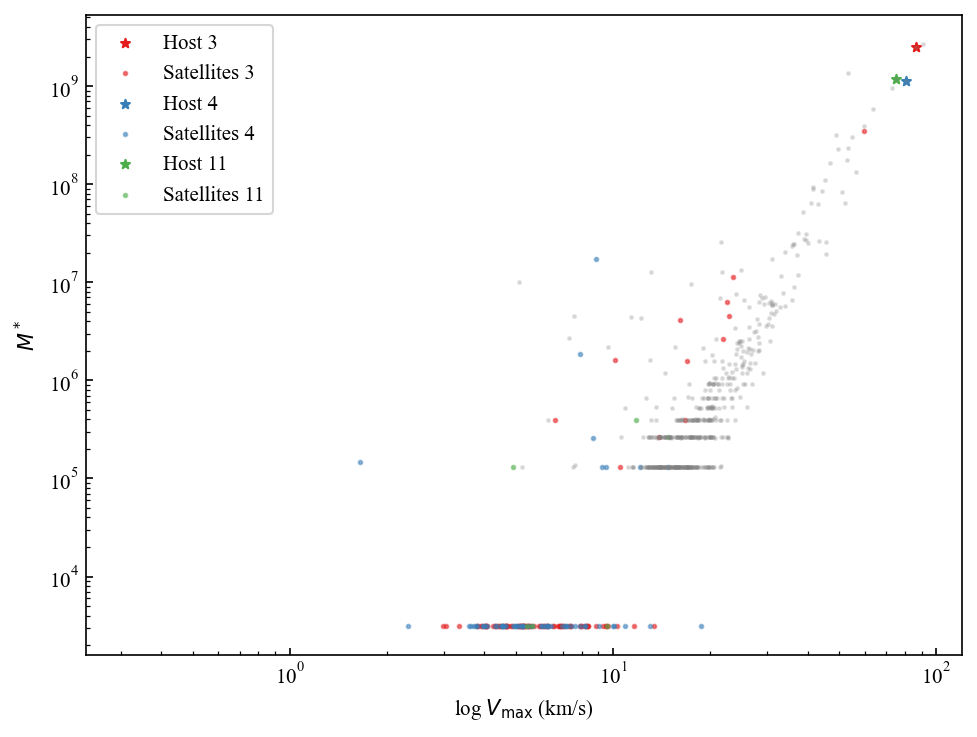

In [12]:

#make stellar mass hallo mass plots for each host and its respective satelites
fig, ax = plt.subplots(dpi=150, constrained_layout=True)
cmap = plt.get_cmap('Set1')
for i in range(len(vol15_df['Host i'])):
    host_id = vol15_df['Host ID'].iloc[i]
    ax.scatter(vol15_df['Host Vmax'].iloc[i], vol15_df['Host M*'].iloc[i], s=20, color = cmap(i), label=f'Host {host_id}', marker='*')
    sat_mstar_array = np.array(vol15_df['Sat M*'].iloc[i])
    # Replace 0 values with 10^4
    sat_mstar_array[sat_mstar_array == 0.0] = 10**3.5 #to distinguish between hosts
    ax.scatter(vol15_df['Sat Vmax'].iloc[i], sat_mstar_array, s=3, color = cmap(i), alpha = 0.5, label=f'Satellites {host_id}')
ax.scatter(vol15_plotsim.main_df['Host Vmax'], vol15_plotsim.main_df['Host M*'], c='Gray', s=2, alpha=0.2)

ax.set_xlabel(r'log $V_{\text{max}}$ (km/s)')
ax.set_ylabel(r'$M^*$')

ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
#fig.suptitle(f'Central Halo SHMH Volume {self.vol}')
fig.show()


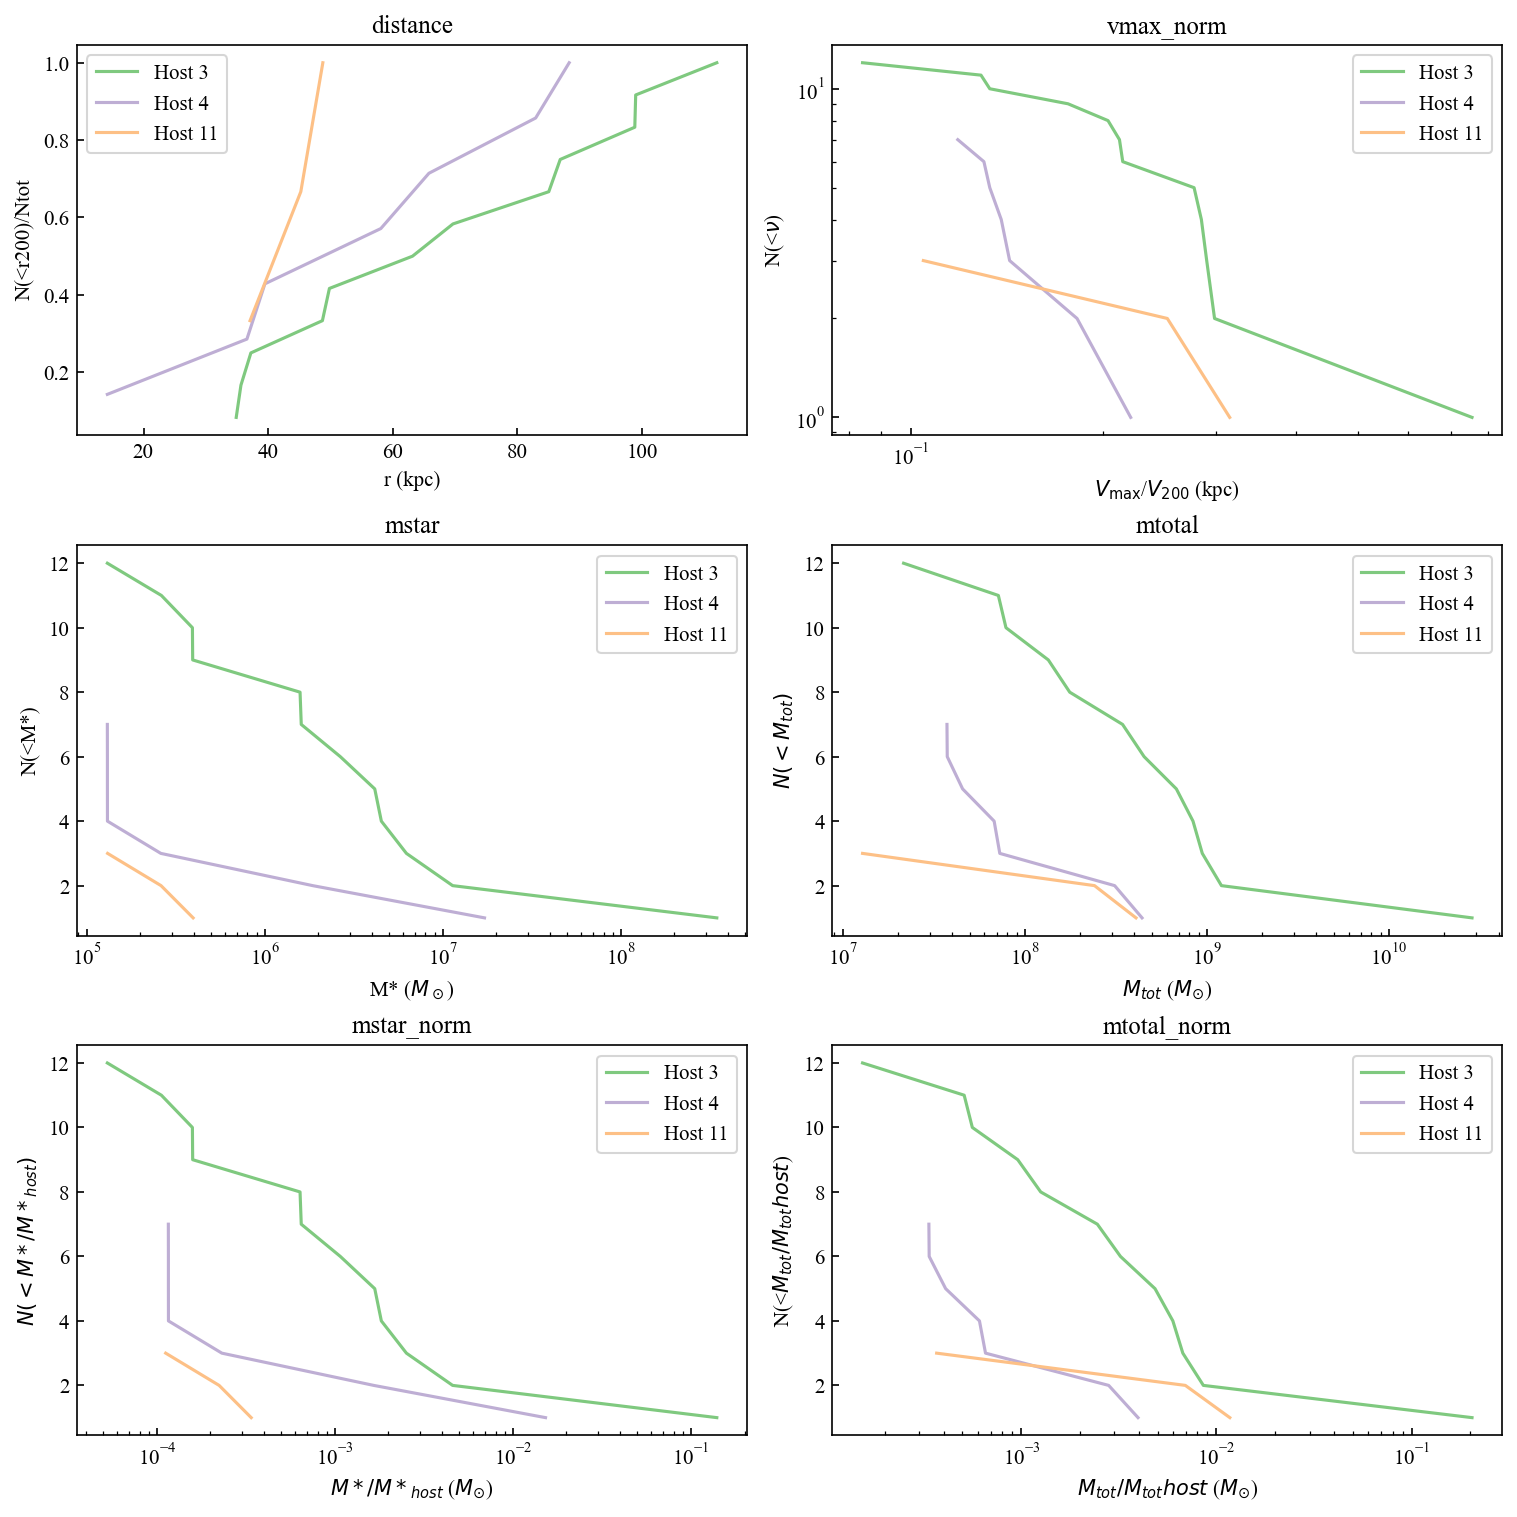

In [24]:
mstar_cut=True

fig, ax = plt.subplots(3, 2, figsize = (10, 10), dpi=150, constrained_layout=True)
ax_flat = ax.flatten()
central_df = vol15_df.copy(deep=True)

for i in vol15_df['Host i']:
    mtot_mask = np.array(vol15_df['Sat Mtot'].loc[i]) > 10**7
    mstar_mask = np.array(vol15_df['Sat M*'].loc[i]) > 1e5
    for col in vol15_plotsim.sat_cols:
        if mstar_cut:
            central_df[col].at[i] = np.array(vol15_df[col].loc[i])[mtot_mask & mstar_mask]
        else:
            central_df[col].at[i] = np.array(vol15_df[col].loc[i])[mtot_mask]

for i in central_df['Host i']:
    r200 = central_df['Host R200'].loc[i]
    v200 = central_df['Host R200'].loc[i]*0.681
    nu = central_df['Sat Vmax'].loc[i]
    host_center = np.array(central_df['Host CoM'].loc[i])
    satellite_centers = central_df['Sat CoM'].loc[i]
    distances = np.array([np.linalg.norm(np.array(sat) - host_center) for sat in satellite_centers]) * 1000

    arrays = {
        'distance': distances,
        'vmax_norm': nu / v200,
        'mstar': central_df['Sat M*'].loc[i], 
        'mtotal': central_df['Sat Mtot'].loc[i], 
        'mstar_norm': central_df['Sat M*'].loc[i] / central_df.loc[i]['Host M*'], 
        'mtotal_norm': central_df['Sat Mtot'].loc[i] / central_df.loc[i]['Host Mtot']
    }
    
    # Loop over the first 6 keys in the arrays dictionary
    for j, key in enumerate(list(arrays.keys())):
        # Get the x values and sort them in reverse order
        x_values = sorted(arrays[key], reverse=True)

        # Determine y values
        if key == 'distance' or key == 'distance_norm':
            y_values = np.linspace(len(x_values), 1, len(x_values)) / len(x_values)
        else:
            ax_flat[j].set_xscale('log')
            y_values = np.arange(1, len(x_values) + 1)

        # Plot the values with a label for the host index
        host_id = vol15_df.loc[i]['Host ID']
        ax_flat[j].plot(x_values, y_values, '-', label=f'Host {host_id}')
        ax_flat[j].set_title(key)
        ax_flat[j].legend()

ax_flat[0].set_xlabel('r (kpc)')
ax_flat[0].set_ylabel('N(<r200)/Ntot')

ax_flat[1].set_xlabel(r'$V_{\text{max}}$/$V_{200}$ (kpc)')
ax_flat[1].set_ylabel(r'N(<$\nu$)')
ax_flat[1].set_yscale('log')
ax_flat[1].set_xscale('log')

ax_flat[2].set_xlabel(r'M* ($M_\odot$)')
ax_flat[2].set_ylabel('N(<M*)')
#ax_flat[2].set_yscale('log')

ax_flat[3].set_xlabel(r'$M_{tot}$ ($M_{\odot}$)')
ax_flat[3].set_ylabel('$N(<M_{tot})$')
#ax_flat[3].set_yscale('log')

ax_flat[4].set_xlabel(r'$M*/M*_{host}$ ($M_{\odot}$)')
ax_flat[4].set_ylabel('$N(<M*/M*_{host})$')
#ax_flat[4].set_yscale('log')

ax_flat[5].set_xlabel(r'$M_{tot}/M_{tot} host$ ($M_{\odot}$)')
ax_flat[5].set_ylabel(r'N(<$M_{tot}/M_{tot} host$)')
#ax_flat[5].set_yscale('log')

#fig.suptitle(f'Individual Central halo satellite properties {self.vol}')

plt.show()

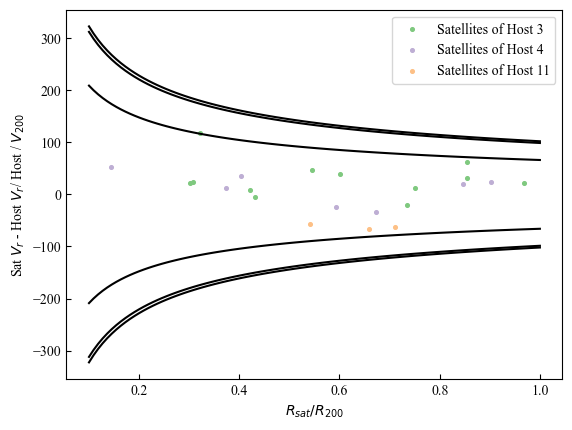

In [64]:
for i in central_df['Host i']:
    host_center = np.array(central_df['Host CoM'].loc[i])
    satellite_centers = central_df['Sat CoM'].loc[i]
    distances = np.array([np.linalg.norm(np.array(sat) - host_center) for sat in satellite_centers])*1000 #kpc
    dist_vector = (np.array(satellite_centers) - host_center)
    dist_vector_norm = [r*1000/dist for r,dist in zip(dist_vector, distances)] #kpc for r*1000 ##fine
    relative_v = central_df['Sat CoMV'].loc[i]-central_df['Host CoMV'].loc[i]
    sat_Vr = [np.dot(v, d) for v,d in zip(dist_vector_norm,relative_v)]
    host_V200 = np.sqrt(central_df['Host R200'].loc[i]*0.681)
    #plt.scatter(distances/central_df['Host R200'].loc[i], (sat_Vr)/host_V200, label=f'Satellites of Host {i+1}', s=7)
    plt.scatter(distances/central_df['Host R200'].loc[i], (sat_Vr), label=f'Satellites of Host {i+1}', s=7)
    dist = np.linspace(0.1,1,100)
    G = 4.3e-6 #kpc
    esc_v =  esc_v = np.sqrt(2 * G * central_df['Host Mtot'].loc[i] / (dist * central_df['Host R200'].loc[i]))
    plt.plot(dist, esc_v, 'Black')
    plt.plot(dist, -esc_v, 'Black')
    #plt.ylim(-5,5)

plt.xlabel(r'$R_{sat}/R_{200}$')
plt.ylabel(r'Sat $V_r$ - Host $V_r$/ Host / $V_{200}$')
plt.legend()
plt.show()

#all sat v luminous sat for all halos in all vols

In [61]:
central_df['Host Mtot'].loc[i]

34823205000.0

In [15]:
data_folder = 'data'
combined_plotsim = SimToolsPlotting(data_folder)
#combined_plotsim.main_df

KeyboardInterrupt: 

In [47]:
combined_plotsim.main_df


Volume  Host i  Host ID  Host R200  \
0            1       0        1  66.825610   
1            1       1        2  59.891380   
2            1       2        3  51.551500   
3            1       3        4  44.031395   
4            1       4        5  43.316277   
...        ...     ...      ...        ...   
995684      25   57822    57823   3.690630   
995685      25   57823    57824   3.019701   
995686      25   57824    57825   2.362903   
995687      25   57825    57826   4.321578   
995688      25   57826    57827   2.085979   

                                                 Host CoM     Host Mtot  \
0       [22.095863342285156, 62.88937759399414, 176.62...  3.192520e+10   
1       [18.187292098999023, 61.3446044921875, 176.817...  2.264636e+10   
2       [20.056503295898438, 54.926326751708984, 182.6...  1.598122e+10   
3       [19.577308654785156, 60.17542266845703, 177.27...  1.081357e+10   
4       [26.465242385864258, 59.23784255981445, 187.44...  7.992674e+09   
...                                                   ...           ...   
995684  [55.624305725097656, 91.85301208496094, 100.18...  9.681278e+06   
995685  [53.75354766845703, 98.64311218261719, 94.9498...  3.025399e+05   
995686                                    [0.0, 0.0, 0.0]  0.000000e+00   
995687  [50.13336181640625, 90.22425842285156, 94.9676...  9.378737e+06   
995688                                    [0.0, 0.0, 0.0]  0.000000e+00   

            Host M*  Host KappaCorot     Host Mhyd    Host Mgas  ...  \
0        44943520.0         0.176485  4.139818e+07  866081856.0  ...   
1       119394860.0         0.184608  2.072630e+07  192915824.0  ...   
2        45367436.0         0.327769  4.281709e+07  168139232.0  ...   
3         3342861.5         0.252710  6.316419e+07  258617568.0  ...   
4        26974474.0         0.185839  2.174759e+04   13180359.0  ...   
...             ...              ...           ...          ...  ...   
995684          0.0         0.000000  0.000000e+00          0.0  ...   
995685          0.0         0.000000  0.000000e+00          0.0  ...   
995686          0.0         0.000000  0.000000e+00          0.0  ...   
995687          0.0         0.000000  0.000000e+00          0.0  ...   
995688          0.0         0.000000  0.000000e+00          0.0  ...   

                                                 Sat Mtot  \
0       [757651520.0, 286595744.0, 200583968.0, 152782...   
1       [212080480.0, 36002244.0, 33279386.0, 24203196...   
2       [120108352.0, 98628016.0, 47498768.0, 37817484...   
3       [115872784.0, 81988312.0, 49919088.0, 41750512...   
4       [136142960.0, 126461680.0, 44775908.0, 3902765...   
...                                                   ...   
995684                                                 []   
995685                                                 []   
995686                                                 []   
995687                                                 []   
995688                                                 []   

                                                   Sat M*  \
0       [394012.8125, 392995.9375, 0.0, 0.0, 0.0, 0.0,...   
1       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
...                                                   ...   
995684                                                 []   
995685                                                 []   
995686                                                 []   
995687                                                 []   
995688                                                 []   

                                                 Sat Mhyd  \
0       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

In [124]:
import pandas as pd
import numpy as np

# Assuming combined_plotsim is already defined and has attributes main_df and sat_cols
# centers is a DataFrame with center coordinates for each volume

central_dfs = []

for vol in combined_plotsim.main_df['Volume'].unique():
    center = np.array([float(c) for c in centers.loc[vol]])
    
    # Get massive host halos within 5 Mpc of volume center
    central_df = combined_plotsim.main_df.loc[(combined_plotsim.main_df['Volume'] == vol) & (combined_plotsim.main_df['Host M*'] > 1e9)]
    
    # Distance mask for host halos
    center_distance_mask = [all(np.abs(host_com - center) < 5) for host_com in central_df['Host CoM']]
    
    # Apply mask to central_df
    central_df = central_df.loc[center_distance_mask]
    
    for i in central_df.index:
        # Distance cut for satellites
        r200 = central_df.at[i, 'Host R200']
        host_center = np.array(central_df.at[i, 'Host CoM'])
        satellite_centers = np.array(central_df.at[i, 'Sat CoM'])
        
        distances = np.array([np.linalg.norm(sat - host_center) for sat in satellite_centers]) * 1000
        distance_mask = distances < r200
        
        for col in combined_plotsim.sat_cols:
            central_df.at[i, col] = np.array(central_df.at[i, col])[distance_mask].tolist()
    
    # Append the processed central_df to the list
    central_dfs.append(central_df)

# Combine all central dataframes into one
combined_central_df = pd.concat(central_dfs, ignore_index=True)
combined_central_df.to_csv('combined_central_df.csv', index=False)

In [6]:
combined_central_df = pd.read_csv('combined_central_df.csv', converters={'Host CoM':pd.eval, 'Host CoMV':pd.eval, 'Sat ID':pd.eval, 'Sat i':pd.eval, 'Sat Mtot':pd.eval, 'Sat M*':pd.eval, 'Sat CoM': pd.eval, 'Sat Mhyd': pd.eval,
            'Sat Mgas':pd.eval,
            'Sat HalfM* radius':pd.eval,
            'Sat M* Metal':pd.eval,
            'Sat M* Iron':pd.eval,
            'Sat vel': pd.eval,
            'Sat Vmax': pd.eval,
            'Sat CoMV': pd.eval})
#combined_plotsim.central_df = combined_central_df

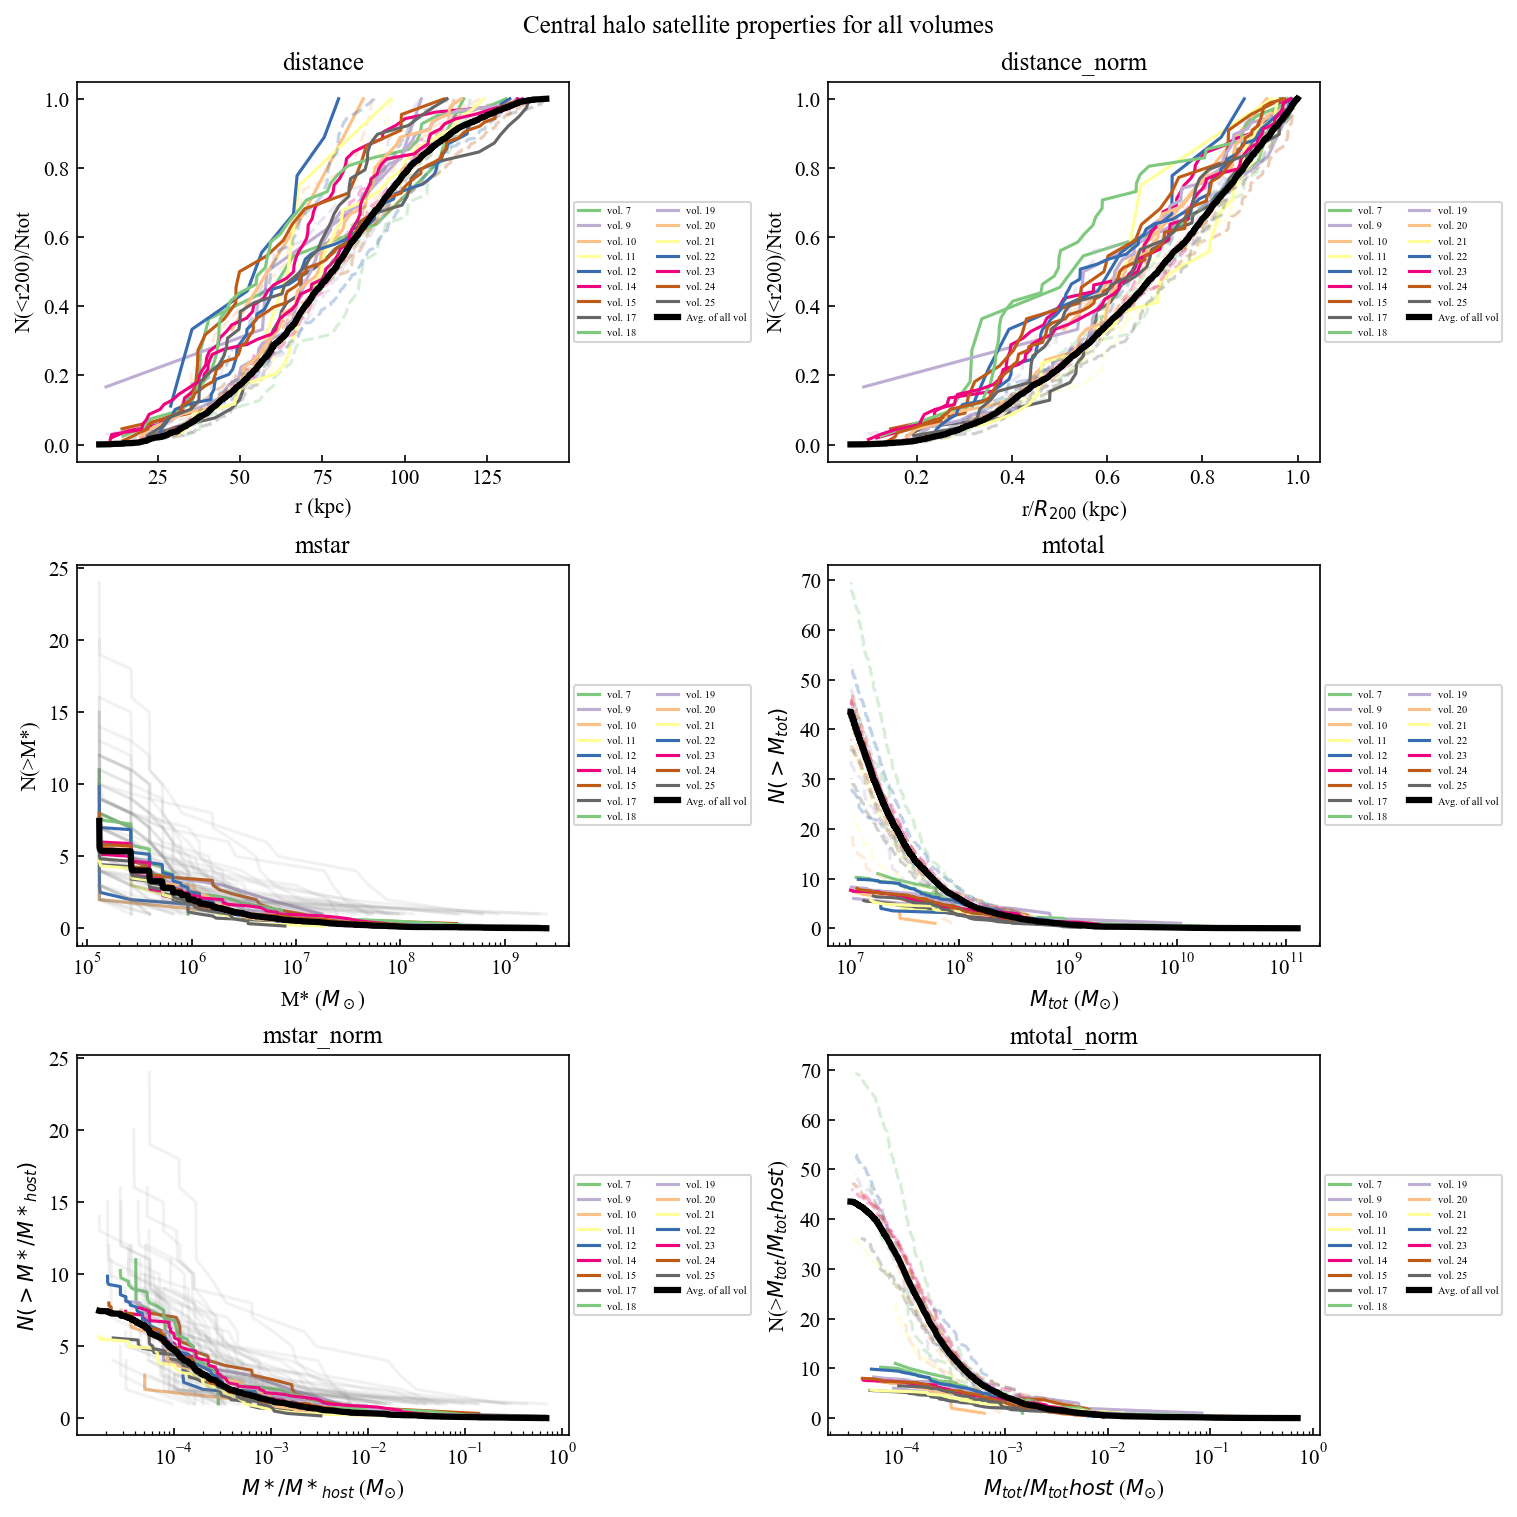

In [18]:
mstar_cut = False
mtot_cut = True
fig, ax = plt.subplots(3, 2, figsize=(10, 10), dpi=150, constrained_layout=True)
ax_flat = ax.flatten()

# Initialize dictionary to store all values
all_array = {
    'distance': [],
    'distance_norm': [],
    'mstar': [],
    'mtotal': [],
    'mstar_norm': [],
    'mtotal_norm': []
}

volumes = combined_central_df['Volume'].unique()
num_haloes = np.array(combined_central_df.groupby('Volume').count()['Host i'])
vol_cut_start = 0

for vol_idx, vol in enumerate(volumes[vol_cut_start:]):
    arrays = {
        'distance': [],
        'distance_norm': [],
        'mstar': [],
        'mtotal': [],
        'mstar_norm': [],
        'mtotal_norm': []
    }

    central_df = combined_central_df[combined_central_df['Volume'] == vol].copy(deep=True)

    mtot_mask = [np.array(central_df['Sat Mtot'].loc[i]) > 10**7 for i in central_df.index]
    for col in vol15_plotsim.sat_cols:
        for i in range(len(mtot_mask)):
            central_df.at[central_df.index[i], col] = np.array(central_df[col].iloc[i])[mtot_mask[i]]

    for i in central_df.index:
        r200 = central_df['Host R200'].loc[i]
        host_center = np.array(central_df['Host CoM'].loc[i])
        satellite_centers = central_df['Sat CoM'].loc[i]
        distances = np.array([np.linalg.norm(np.array(sat) - host_center) for sat in satellite_centers]) * 1000

        sat_mstar = central_df['Sat M*'].loc[i]
        sat_mtot = central_df['Sat Mtot'].loc[i]

        arrays['distance'].append(distances)
        arrays['distance_norm'].append(distances / r200)
        arrays['mstar'].append(sat_mstar)
        arrays['mtotal'].append(sat_mtot)
        arrays['mstar_norm'].append(sat_mstar / central_df['Host M*'].loc[i])
        arrays['mtotal_norm'].append(sat_mtot / central_df['Host Mtot'].loc[i])

    non_zero_mask = np.concatenate([np.array(array) != 0 for array in arrays['mstar']])

    for j, key in enumerate(arrays.keys()):
        if key in ['distance', 'distance_norm']:
            arrays[key] = np.concatenate(arrays[key])

            nonzero_x_values = sorted(arrays[key][non_zero_mask], reverse=True)
            total_x_values = sorted(arrays[key], reverse=True)

            nonzero_y_values = np.linspace(len(nonzero_x_values), 1, len(nonzero_x_values)) / len(nonzero_x_values)
            total_y_values = np.linspace(len(total_x_values), 1, len(total_x_values)) / len(total_x_values)

            ax_flat[j].plot(nonzero_x_values, nonzero_y_values, c=clrs[vol_idx % len(clrs)], label=f'vol. {vol}')
            ax_flat[j].plot(total_x_values, total_y_values, '--', c=clrs[vol_idx % len(clrs)], alpha=0.3)
            ax_flat[j].set_title(key)
            ax_flat[j].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, fontsize=5)

        elif key in ['mtotal', 'mtotal_norm']:
            arrays[key] = np.concatenate(arrays[key])

            nonzero_x_values = sorted(arrays[key][non_zero_mask], reverse=True)
            total_x_values = sorted(arrays[key], reverse=True)

            nonzero_y_values = np.arange(1, len(nonzero_x_values) + 1) / len(central_df)
            total_y_values = np.arange(1, len(total_x_values) + 1) / len(central_df)

            ax_flat[j].plot(nonzero_x_values, nonzero_y_values, c=clrs[vol_idx % len(clrs)], label=f'vol. {vol}')
            ax_flat[j].plot(total_x_values, total_y_values,  '--', c=clrs[vol_idx % len(clrs)], alpha=0.3)
            ax_flat[j].set_title(key)
            ax_flat[j].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, fontsize=5)

        else:
            mstar_cut_mask = np.concatenate([np.array(array) > 1e5 for array in arrays['mstar']])
            mstar_concatenated = np.concatenate(arrays[key])[mstar_cut_mask]
            x_values_conc = sorted(mstar_concatenated, reverse=True)
            ax_flat[j].set_xscale('log')
            y_values_conc = np.arange(1, len(x_values_conc) + 1) / len(central_df)
            ax_flat[j].plot(x_values_conc, y_values_conc, c=clrs[vol_idx % len(clrs)], label=f'vol. {vol}')
            ax_flat[j].set_title(key)
            for i, array in enumerate(arrays[key]):
                x_values = sorted(array[arrays['mstar'][i]>1e5], reverse=True)
                y_values = np.arange(1, len(x_values) + 1)
                ax_flat[j].plot(x_values, y_values, alpha=0.1, c='gray')
            

        all_array[key].append(arrays[key])

for k, key in enumerate(all_array.keys()):
    
    if key in ['distance', 'distance_norm']:
        combined_values = np.concatenate(all_array[key])
        x_values = sorted(combined_values, reverse=True)
        y_values = np.linspace(len(x_values), 1, len(x_values)) / len(x_values)
    elif key in ['mtotal', 'mtotal_norm']:
        combined_values = np.concatenate(all_array[key])
        x_values = sorted(combined_values, reverse=True)
        y_values = np.arange(1, len(x_values) + 1) / np.sum(num_haloes[vol_cut_start:])
    else:
        combined_values = np.concatenate([item for sublist in all_array[key] for item in sublist])
        mstar_cut_mask = np.concatenate([item for sublist in all_array['mstar'] for item in sublist]) > 1e5
        combined_values = combined_values[mstar_cut_mask]
        x_values = sorted(combined_values, reverse=True)
        y_values = np.arange(1, len(x_values) + 1) / np.sum(num_haloes[vol_cut_start:])


    ax_flat[k].plot(x_values, y_values, lw=3, c='black', label='Avg. of all vol')
    ax_flat[k].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, fontsize=5)

ax_flat[0].set_xlabel('r (kpc)')
ax_flat[0].set_ylabel('N(<r200)/Ntot')

ax_flat[1].set_xlabel(r'r/$R_{200}$ (kpc)')
ax_flat[1].set_ylabel('N(<r200)/Ntot')

ax_flat[2].set_xlabel(r'M* ($M_\odot$)')
ax_flat[2].set_ylabel('N(>M*)')

ax_flat[3].set_xlabel(r'$M_{tot}$ ($M_{\odot}$)')
ax_flat[3].set_ylabel('$N(>M_{tot})$')
ax_flat[3].set_xscale('log')

ax_flat[4].set_xlabel(r'$M*/M*_{host}$ ($M_{\odot}$)')
ax_flat[4].set_ylabel('$N(>M*/M*_{host})$')

ax_flat[5].set_xlabel(r'$M_{tot}/M_{tot} host$ ($M_{\odot}$)')
ax_flat[5].set_ylabel(r'N(>$M_{tot}/M_{tot} host$)')
ax_flat[5].set_xscale('log')

fig.suptitle('Central halo satellite properties for all volumes')
plt.show()
#luminous satellites by host instead of volume (don't change the average)
#Average lines hows the average of all hosts (not just luminous)
#we want to see the scatter around the luminous (so make an average line in luminous as well)
#! What is the radius that comntains half od the satellites? (quote in paper)
#! Talk about how many luminous satellites there are on average, and ratio of non-luminous satellites to lum.Useful numbers to quote (population analysis) 


ratio of non-luminous to luminous satellites
- Have to find bin centers and bin the arrays. Tells you ratio at various Host mass

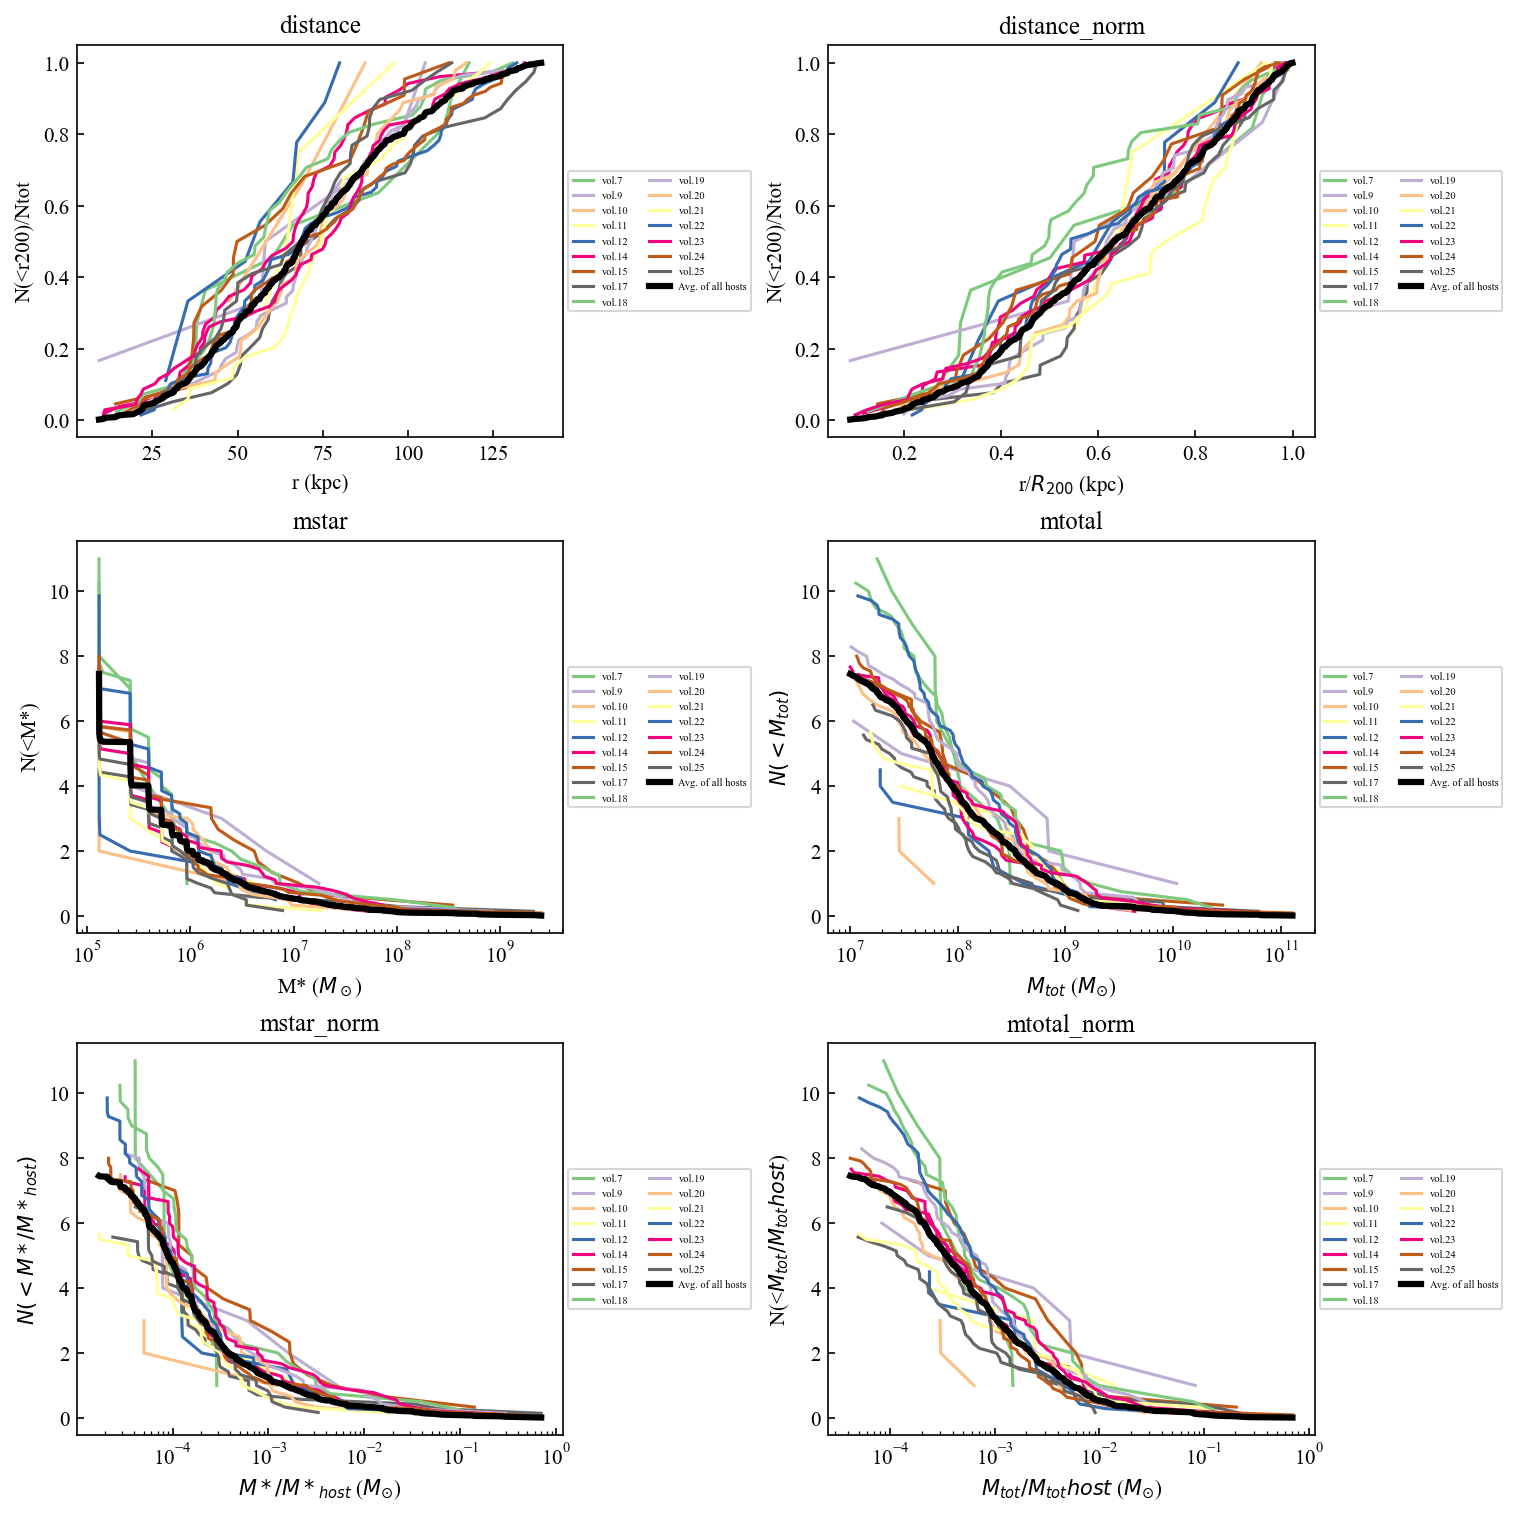

In [22]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 2, figsize=(10, 10), dpi=150, constrained_layout=True)
ax_flat = ax.flatten()
volumes = combined_central_df['Volume'].unique()
all_array = {
    'distance': [],
    'distance_norm': [],
    'mstar': [],
    'mtotal': [],
    'mstar_norm': [],
    'mtotal_norm': []
}
num_haloes = np.array(combined_central_df.groupby('Volume').count()['Host i'])

for vol in volumes:
    arrays = {
        'distance': [],
        'distance_norm': [],
        'mstar': [],
        'mtotal': [],
        'mstar_norm': [],
        'mtotal_norm': []
    }

    central_df = combined_central_df[combined_central_df['Volume'] == vol].copy(deep=True)

    mtot_mask = [np.array(central_df['Sat Mtot'].loc[i]) > 10**7 for i in central_df.index]
    mstar_mask = [np.array(central_df['Sat M*'].loc[i]) > 1e5 for i in central_df.index]
    for col in vol15_plotsim.sat_cols:
        for i in range(len(mtot_mask)):
            filtered_data = np.array(central_df[col].iloc[i])[mtot_mask[i] & mstar_mask[i]]
            central_df.at[central_df.index[i], col] = list(filtered_data)

    for i in central_df.index:
        r200 = central_df['Host R200'].loc[i]
        host_center = np.array(central_df['Host CoM'].loc[i])
        satellite_centers = central_df['Sat CoM'].loc[i]
        distances = np.array([np.linalg.norm(np.array(sat) - host_center) for sat in satellite_centers]) * 1000

        sat_mstar = central_df['Sat M*'].loc[i]
        sat_mtot = central_df['Sat Mtot'].loc[i]

        arrays['distance'].append(distances)
        arrays['distance_norm'].append(distances / r200)
        arrays['mstar'].append(sat_mstar)
        arrays['mtotal'].append(sat_mtot)
        arrays['mstar_norm'].append(sat_mstar / central_df['Host M*'].loc[i])
        arrays['mtotal_norm'].append(sat_mtot / central_df['Host Mtot'].loc[i])

    # Loop over the first 6 keys in the arrays dictionary
    for j, key in enumerate(list(arrays.keys())):
        all_array[key].extend(arrays[key])
        non_empty_arrays = [arr for arr in arrays[key] if len(arr) > 0]
        if non_empty_arrays:  # Ensure there are non-empty arrays to process
            conc = list(non_empty_arrays[0])
            for arr in non_empty_arrays[1:]:
                conc.extend(arr)

            x_values = sorted(conc, reverse=True)
            if key == 'distance' or key == 'distance_norm':
                y_values = np.linspace(len(x_values), 1, len(x_values)) / len(x_values)
            else:
                ax_flat[j].set_xscale('log')
                y_values = np.arange(1, len(x_values) + 1) / len(central_df)

            # Plot the values with a label for the host index
            ax_flat[j].plot(x_values, y_values, '-', label=f'vol.{vol}', alpha = 0.5)
            ax_flat[j].set_title(key)
            ax_flat[j].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, fontsize=5)

for k, key in enumerate(all_array.keys()):
    non_empty_allarrays = [arr for sublist in all_array[key] for arr in sublist if arr.any()]
    combined_values = sorted(non_empty_allarrays, reverse=True)
    if key in ['distance', 'distance_norm']:
        y_values = np.linspace(len(combined_values), 1, len(combined_values)) / len(combined_values)
    else:
        y_values = np.arange(1, len(combined_values) + 1) / np.sum(num_haloes)

    ax_flat[k].plot(combined_values, y_values, lw=3, c='black', label='Avg. of all hosts')
    ax_flat[k].legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, fontsize=5)

# Set axis labels
ax_flat[0].set_xlabel('r (kpc)')
ax_flat[0].set_ylabel('N(<r200)/Ntot')

ax_flat[1].set_xlabel(r'r/$R_{200}$ (kpc)')
ax_flat[1].set_ylabel('N(<r200)/Ntot')

ax_flat[2].set_xlabel(r'M* ($M_\odot$)')
ax_flat[2].set_ylabel('N(<M*)')

ax_flat[3].set_xlabel(r'$M_{tot}$ ($M_{\odot}$)')
ax_flat[3].set_ylabel(r'$N(<M_{tot})$')

ax_flat[4].set_xlabel(r'$M*/M*_{host}$ ($M_{\odot}$)')
ax_flat[4].set_ylabel(r'$N(<M*/M*_{host})$')

ax_flat[5].set_xlabel(r'$M_{tot}/M_{tot} host$ ($M_{\odot}$)')
ax_flat[5].set_ylabel(r'N(<$M_{tot}/M_{tot} host$)')

plt.show()

#more useful to see lines per host in the distances, then the average is actually the average


16 589
